In [788]:
import numpy as np
import pandas as pd
%matplotlib notebook
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from mpl_toolkits.mplot3d import axes3d, Axes3D 
from sklearn.metrics import r2_score
import os
import time
os.environ["PATH"] += "/home/dalakoti/geppy"
import geppy as gep
import operator
from deap import tools, creator, base 
import random
import sympy as sp
from sklearn.linear_model import LinearRegression as LR
from sklearn.linear_model import RidgeCV, LassoCV, Lasso, SGDRegressor
from scipy.signal import savgol_filter
import matplotlib.ticker as ticker
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
import pickle
from sklearn.ensemble import RandomForestRegressor
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Dropout, GaussianNoise
from keras.losses import logcosh
from sklearn.svm import SVR
import glob
import xgboost as xgb
from sklearn.model_selection import train_test_split

#from numpy import exp


In [ ]:
Gij = np.loadtxt('../GLM/t1/Gij.dat')
Tij = np.loadtxt('../GLM/t1/Tij.dat')
K   = np.loadtxt('../GLM/t1/k-eps.dat')
Sij   = np.loadtxt('../GLM/t1/Sij.dat')
omega = np.loadtxt('../GLM/t1/omega.dat')
meanVelGrad = np.loadtxt('../GLM/t1/mean_vel_grad.dat')

loend = 230
hiend = 350


eps = np.copy(K[:,1])
K   = K[:,0]

Gij = Gij[loend:hiend,:]
Tij = Tij[loend:hiend,:]
meanVelGrad = meanVelGrad[loend:hiend,:]
eps = eps[loend:hiend]
K = K[loend:hiend]
omega = omega[loend:hiend,:]
Sij = Sij[loend:hiend,:]


b = np.copy(Tij)
b[:,0] = b[:,0]-2.0*K/3.0
b[:,4] = b[:,4]-2.0*K/3.0
b[:,8] = b[:,8]-2.0*K/3.0
tau = K/eps

In [ ]:
Gij = Gij/1e5

In [ ]:
plt.figure()
plt.plot(Gij[:,2])

In [ ]:
#Isotropic turbulence case
Gij = np.loadtxt('../GLM/iso/Gij.dat')
Tij = np.loadtxt('../GLM/iso/Tij.dat')
K   = np.loadtxt('../GLM/iso/k-eps.dat')
eps = K[:,1]
K   = K[:,0]
Sij   = np.loadtxt('../GLM/iso/Sij.dat')
omega = np.loadtxt('../GLM/iso/omega.dat')
meanVelGrad = np.loadtxt('../GLM/iso/mean_vel_grad.dat')
b = np.copy(Tij)
b[:,0] = b[:,0]-2.0*K/3.0
b[:,4] = b[:,4]-2.0*K/3.0
b[:,8] = b[:,8]-2.0*K/3.0
tau = K/eps
#Gij = 0 


In [ ]:
Gij.shape

In [ ]:
tempij = np.loadtxt('../GLM/t1/Tij.dat')
tempij = np.reshape(tempij,(tempij.shape[0],3,3))
lambdaij = np.zeros((tempij.shape[0],3,3))
for i in range(0,lambdaij.shape[0]):
    lambdaij[i,:,:] = np.linalg.inv(tempij[i,:,:])
lambdaij = lambdaij[loend:hiend,:,:]
lambdaij = lambdaij*K[:,None,None]

In [ ]:
sz = 11
for i in range(0,9):
    Gij[:,i] = savgol_filter(Gij[:,i], sz, 3) # window size 51, polynomial order 3
    meanVelGrad[:,i] = savgol_filter(meanVelGrad[:,i], 11, 3) # window size 51, polynomial order 3
    Tij[:,i] = savgol_filter(Tij[:,i], sz, 3) # window size 51, polynomial order 3
    omega[:,i] = savgol_filter(omega[:,i], sz, 3) # window size 51, polynomial order 3
    Sij[:,i] = savgol_filter(Sij[:,i], sz, 3) # window size 51, polynomial order 3
    b[:,i] = savgol_filter(b[:,i], sz, 3) # window size 51, polynomial order 3
    #lambdaij[:,i] = savgol_filter(lambdaij[:,i], sz, 3) # window size 51, polynomial order 3
K = savgol_filter(K, sz, 3) # window size 51, polynomial order 3
eps = savgol_filter(eps, sz, 3) # window size 51, polynomial order 3

In [ ]:
Gij = np.reshape(Gij,(Gij.shape[0],3,3))
Tij = np.reshape(Tij,(Tij.shape[0],3,3))
meanVelGrad = np.reshape(meanVelGrad,(meanVelGrad.shape[0],3,3))
Sij = np.reshape(Sij,(Sij.shape[0],3,3))
omega = np.reshape(omega,(omega.shape[0],3,3))
b = np.reshape(b,(b.shape[0],3,3))
detT = np.zeros(b.shape[0])
I2 = np.zeros(b.shape[0])
for i in range(0,b.shape[0]):
    detT[i] = 1.0/np.linalg.det(Tij[i,:,:])
    I2[i] = 0.5*(np.trace(Tij[i,:,:])**2 - np.trace(np.matmul(Tij[i,:,:],Tij[i,:,:])))

In [ ]:
accu = np.loadtxt('../GLM/accu.dat')
accu = np.reshape(accu,(accu.shape[0],3,3))


In [ ]:
basis_vect = np.zeros((K.shape[0],3,3,19))
trace = np.zeros((K.shape[0],19))
norm_const = np.zeros((K.shape[0],19))

In [ ]:
Gij = Gij*K[:,None,None]/eps[:,None,None]
Tij = Tij/K[:,None,None]
meanVelGrad = meanVelGrad*K[:,None,None]/eps[:,None,None]
Sij = Sij*K[:,None,None]/eps[:,None,None]
omega = omega*K[:,None,None]/eps[:,None,None]
b = b/(2.0*K[:,None,None])
detT = detT*K**3
I2 = I2/K**2

In [ ]:
#NEW BASIS VECT
basis_vect[:,:,:,0] = b
basis_vect[:,:,:,1] = Sij
basis_vect[:,:,:,2] = omega
basis_vect[:,:,:,3] = np.matmul(Sij,b)
basis_vect[:,:,:,4] = np.matmul(omega,b)
basis_vect[:,:,:,5] = np.matmul(b,Sij)
basis_vect[:,:,:,6] = np.matmul(b,b)
basis_vect[:,:,:,7] = np.matmul(b,omega)
#basis_vect[:,:,:,7] = np.matmul(Tij,omega)
basis_vect[:,:,:,8] = np.matmul(basis_vect[:,:,:,6],b)
basis_vect[:,:,:,9] = np.matmul(basis_vect[:,:,:,7],b)



In [ ]:
#NEW BASIS VECT
basis_vect[:,:,:,0] = b
basis_vect[:,:,:,1] = np.matmul(b,b)
#basis_vect[:,:,:,2] = np.matmul(np.matmul(b,b),b)
basis_vect[:,:,:,2] = Sij
basis_vect[:,:,:,3] = omega  
basis_vect[:,:,:,4] = np.matmul(Sij,b)
basis_vect[:,:,:,5] = np.matmul(omega,b)
basis_vect[:,:,:,6] = np.matmul(b,Sij)
basis_vect[:,:,:,7] = np.matmul(b,omega)
#basis_vect[:,:,:7] = np.matmul(Tij,omega)
basis_vect[:,:,:,8] = np.matmul(basis_vect[:,:,:,6],b)
basis_vect[:,:,:,9] = np.matmul(basis_vect[:,:,:,7],b)
basis_vect[:,:,:,10] = np.matmul(basis_vect[:,:,:,2],basis_vect[:,:,:,1])
basis_vect[:,:,:,11] = np.matmul(basis_vect[:,:,:,3],basis_vect[:,:,:,1])
basis_vect[:,:,:,12] = np.matmul(basis_vect[:,:,:,1],basis_vect[:,:,:,2])
basis_vect[:,:,:,13] = np.matmul(basis_vect[:,:,:,1],basis_vect[:,:,:,3])
basis_vect[:,:,:,14] = np.matmul(np.matmul(b,b),b)
for i in range(0,K.shape[0]):
       basis_vect[i,:,:,15] = np.eye(3,3)*np.trace(Sij)
       basis_vect[i,:,:,16] = np.trace(basis_vect[i,:,:,4])*np.eye(3,3)
       basis_vect[i,:,:,17] = np.trace(np.matmul(basis_vect[i,:,:,2],basis_vect[i,:,:,1]))*np.eye(3,3)
       #basis_vect[i,:,:,17] = np.trace(np.matmul(basis_vect[i,:,:,2],basis_vect[i,:,:,1]))*np.eye(3,3)
       


In [ ]:
hof[0].a

In [ ]:
#NEW BASIS VECT
basis_vect[:,:,:,0] = b

for i in range(0,K.shape[0]):
    basis_vect[i,:,:,1] = np.matmul(b[i,:,:],b[i,:,:])-1.0/3*np.trace(np.matmul(b[i,:,:],b[i,:,:]))*np.eye(3,3)
    basis_vect[i,:,:,2] = Sij[i,:,:] - 1.0/3*np.trace(Sij[i,:,:])*np.eye(3,3)
    basis_vect[i,:,:,3] = np.matmul(Sij[i,:,:],b[i,:,:]) + np.transpose(np.matmul(Sij[i,:,:],b[i,:,:])) - 2.0/3*np.trace(np.matmul(Sij[i,:,:],b[i,:,:]))*np.eye(3,3)
    

    basis_vect[i,:,:,4] = np.matmul(omega[i,:,:],b[i,:,:]) + np.transpose(np.matmul(omega[i,:,:],b[i,:,:]))


    basis_vect[i,:,:,5] = np.matmul(Sij[i,:,:],np.matmul(b[i,:,:],b[i,:,:])) + \
        np.transpose(np.matmul(Sij[i,:,:],np.matmul(b[i,:,:],b[i,:,:]))) - \
        2.0/3*(np.trace(np.matmul(Sij[i,:,:],np.matmul(b[i,:,:],b[i,:,:]))))
                           
        
    basis_vect[i,:,:,6] = np.matmul(omega[i,:,:],np.matmul(b[i,:,:],b[i,:,:])) + np.transpose(np.matmul(omega[i,:,:],np.matmul(b[i,:,:],b[i,:,:])))
    basis_vect[i,:,:,7] = np.matmul(np.matmul(b[i,:,:],Sij[i,:,:]),b[i,:,:])-1.0/3*np.trace(np.matmul(Sij[i,:,:],np.matmul(b[i,:,:],b[i,:,:])))*np.eye(3,3)
    
basis_vect[:,:,:,8] = np.matmul(basis_vect[:,:,:,6],b)
basis_vect[:,:,:,9] = np.matmul(basis_vect[:,:,:,7],b)

In [ ]:
Tij.shape

In [ ]:
basis_vect[:,:,:,0]=b
for i in range(0,K.shape[0]):
    basis_vect[i,:,:,1]=np.trace(meanVelGrad[i,:,:])*np.eye(3,3)
    basis_vect[i,:,:,2]=meanVelGrad[i,:,:]
    basis_vect[i,:,:,3]=np.transpose(meanVelGrad[i,:,:])
    basis_vect[i,:,:,4]=np.trace(np.matmul(meanVelGrad[i,:,:],b[i,:,:]))*np.eye(3,3)
    basis_vect[i,:,:,5]=np.transpose(np.matmul(b[i,:,:],np.transpose(meanVelGrad[i,:,:])))
    basis_vect[i,:,:,6]=np.transpose(np.matmul(b[i,:,:],meanVelGrad[i,:,:]))    
    basis_vect[i,:,:,7]=b[i,:,:]*np.trace(meanVelGrad[i,:,:])
    basis_vect[i,:,:,8]=np.matmul(b[i,:,:],meanVelGrad[i,:,:])    
    basis_vect[i,:,:,9]=np.matmul(b[i,:,:],np.transpose(meanVelGrad[i,:,:]))
    basis_vect[i,:,:,10]=np.trace(np.matmul(np.matmul(b[i,:,:],b[i,:,:]),b[i,:,:]))*np.eye(3,3)
    #basis_vect[i,:,:,11] = - 0.5*np.trace(np.matmul(Tij[i,:,:],np.transpose(meanVelGrad[i,:,:])) + np.transpose(np.matmul(Tij[i,:,:],np.transpose(meanVelGrad[i,:,:]))))
    basis_vect[i,:,:,11]=np.matmul(b[i,:,:],b[i,:,:])
    basis_vect[i,:,:,12]=np.eye(3,3)


In [ ]:
for i in range(0,K.shape[0]):
    basis_vect[i,:,:,0]=np.eye(3,3)*eps[i]/K[i]
    basis_vect[i,:,:,1]=b[i,:,:]*eps[i]/K[i]    
    basis_vect[i,:,:,2]=np.matmul(b[i,:,:],b[i,:,:])*eps[i]/K[i]    
    basis_vect[i,:,:,3]=np.trace(meanVelGrad[i,:,:])*np.eye(3,3)
    basis_vect[i,:,:,4]=meanVelGrad[i,:,:]
    basis_vect[i,:,:,5]=np.transpose(meanVelGrad[i,:,:])
    basis_vect[i,:,:,6]=np.trace(np.matmul(meanVelGrad[i,:,:],b[i,:,:]))*np.eye(3,3)
    basis_vect[i,:,:,7]=np.transpose(np.matmul(b[i,:,:],meanVelGrad[i,:,:]))
    basis_vect[i,:,:,8]=b[i,:,:]*np.trace(meanVelGrad[i,:,:])
    basis_vect[i,:,:,9]=b[i,:,:]*np.trace(meanVelGrad[i,:,:])
    basis_vect[i,:,:,10]=np.matmul(b[i,:,:],meanVelGrad[i,:,:])    
    basis_vect[i,:,:,11]=np.transpose(np.matmul(meanVelGrad[i,:,:],b[i,:,:]))    
    basis_vect[i,:,:,12]=np.trace(np.matmul(np.matmul(b[i,:,:],b[i,:,:]),b[i,:,:]))*np.eye(3,3)
    P = - 0.5*np.trace(np.matmul(Tij[i,:,:],np.transpose(meanVelGrad[i,:,:])) + np.transpose(np.matmul(Tij[i,:,:],np.transpose(meanVelGrad[i,:,:]))))
    basis_vect[i,:,:,13] = P/eps[i]
    #basis_vect[i,:,:,12]=np.matmul(b[i,:,:],b[i,:,:])
    #basis_vect[i,:,:,13]=np.eye(3,3)


In [ ]:
meanVelGrad.shape

In [ ]:
basis_vect.shape

In [ ]:
plt.figure()
plt.plot(basis_vect[:,0,0,3]+basis_vect[:,1,1,3]+basis_vect[:,2,2,3])

In [ ]:
basis_vect[:,:,:,0]= Tij
basis_vect[:,:,:,1]= meanVelGrad
basis_vect[:,:,:,2]= np.matmul(Tij,Tij)
basis_vect[:,:,:,3]= np.matmul(meanVelGrad,meanVelGrad)
basis_vect[:,:,:,4]= np.matmul(Tij,meanVelGrad)
basis_vect[:,:,:,5]= np.matmul(meanVelGrad,Tij)
basis_vect[:,:,:,6]= np.matmul(basis_vect[:,:,:,2],meanVelGrad)
basis_vect[:,:,:,7]= np.matmul(basis_vect[:,:,:,3],Tij)
basis_vect[:,:,:,8]= np.matmul(Tij,basis_vect[:,:,:,3])
basis_vect[:,:,:,9]= np.matmul(meanVelGrad,basis_vect[:,:,:,2])
basis_vect[:,:,:,10]= np.matmul(basis_vect[:,:,:,2],basis_vect[:,:,:,3])
basis_vect[:,:,:,11]= np.matmul(basis_vect[:,:,:,3],basis_vect[:,:,:,2])
basis_vect[:,:,:,12]= np.matmul(basis_vect[:,:,:,4],basis_vect[:,:,:,2])
basis_vect[:,:,:,13]= np.matmul(basis_vect[:,:,:,5],basis_vect[:,:,:,3])
basis_vect[:,:,:,14]= np.matmul(basis_vect[:,:,:,0],basis_vect[:,:,:,11])
basis_vect[:,:,:,15]= np.matmul(basis_vect[:,:,:,1],basis_vect[:,:,:,10])

#basis_vect[:,:,:,10]= np.matmul(Tij**2,meanVelGrad**2)
#basis_vect[:,:,:,11]= np.matmul(meanVelGrad**2,Tij**2)
#basis_vect[:,:,:,12]= Tij*meanVelGrad*Tij**2
#basis_vect[:,:,:,13]= meanVelGrad*Tij*meanVelGrad**2
#basis_vect[:,:,:,14]= Tij*meanVelGrad**2*Tij**2
#basis_vect[:,:,:,15]= meanVelGrad*Tij**2*meanVelGrad**2


In [ ]:
basis_vect[:,:,:,0]= np.eye(3,3)[None,:,:]
basis_vect[:,:,:,1]= Tij
basis_vect[:,:,:,2]= meanVelGrad
basis_vect[:,:,:,3]= np.matmul(Tij,Tij)
basis_vect[:,:,:,4]= np.matmul(meanVelGrad,meanVelGrad)
basis_vect[:,:,:,5]= np.matmul(Tij,meanVelGrad)
basis_vect[:,:,:,6]= np.matmul(meanVelGrad,Tij)
basis_vect[:,:,:,7]= np.matmul(basis_vect[:,:,:,2],meanVelGrad)
basis_vect[:,:,:,8]= np.matmul(basis_vect[:,:,:,3],Tij)
basis_vect[:,:,:,9]= np.matmul(Tij,basis_vect[:,:,:,3])
basis_vect[:,:,:,10]= np.matmul(meanVelGrad,basis_vect[:,:,:,2])
basis_vect[:,:,:,11]= np.matmul(basis_vect[:,:,:,2],basis_vect[:,:,:,3])
basis_vect[:,:,:,12]= np.matmul(basis_vect[:,:,:,3],basis_vect[:,:,:,2])
basis_vect[:,:,:,13]= np.matmul(basis_vect[:,:,:,4],basis_vect[:,:,:,2])
basis_vect[:,:,:,14]= np.matmul(basis_vect[:,:,:,5],basis_vect[:,:,:,3])
basis_vect[:,:,:,15]= np.matmul(basis_vect[:,:,:,0],basis_vect[:,:,:,11])
basis_vect[:,:,:,16]= np.matmul(basis_vect[:,:,:,1],basis_vect[:,:,:,10])
basis_vect[i,:,:,17]=np.trace(np.matmul(np.matmul(Tij[i,:,:],Tij[i,:,:]),Tij[i,:,:]))*np.eye(3,3)
P = - 0.5*np.trace(np.matmul(Tij[i,:,:],np.transpose(meanVelGrad[i,:,:])) + np.transpose(np.matmul(Tij[i,:,:],np.transpose(meanVelGrad[i,:,:]))))
basis_vect[i,:,:,18] = P

#basis_vect[:,:,:,10]= np.matmul(Tij**2,meanVelGrad**2)
#basis_vect[:,:,:,11]= np.matmul(meanVelGrad**2,Tij**2)
#basis_vect[:,:,:,12]= Tij*meanVelGrad*Tij**2
#basis_vect[:,:,:,13]= meanVelGrad*Tij*meanVelGrad**2
#basis_vect[:,:,:,14]= Tij*meanVelGrad**2*Tij**2
#basis_vect[:,:,:,15]= meanVelGrad*Tij**2*meanVelGrad**2


In [ ]:
basis_vect[:,:,:,0]= np.eye(3,3)[None,:,:]
basis_vect[:,:,:,1]= b
basis_vect[:,:,:,2]= meanVelGrad
basis_vect[:,:,:,3]= np.matmul(b,b)
basis_vect[:,:,:,4]= np.matmul(meanVelGrad,meanVelGrad)
basis_vect[:,:,:,5]= np.matmul(b,meanVelGrad)
basis_vect[:,:,:,6]= np.matmul(meanVelGrad,Tij)
basis_vect[:,:,:,7]= np.matmul(basis_vect[:,:,:,2],meanVelGrad)
basis_vect[:,:,:,8]= np.matmul(basis_vect[:,:,:,3],b)
basis_vect[:,:,:,9]= np.matmul(b,basis_vect[:,:,:,3])
basis_vect[:,:,:,10]= np.matmul(meanVelGrad,basis_vect[:,:,:,2])
basis_vect[:,:,:,11]= np.matmul(basis_vect[:,:,:,2],basis_vect[:,:,:,3])
basis_vect[:,:,:,12]= np.matmul(basis_vect[:,:,:,3],basis_vect[:,:,:,2])
basis_vect[:,:,:,13]= np.matmul(basis_vect[:,:,:,4],basis_vect[:,:,:,2])
basis_vect[:,:,:,14]= np.matmul(basis_vect[:,:,:,5],basis_vect[:,:,:,3])
basis_vect[:,:,:,15]= np.matmul(basis_vect[:,:,:,0],basis_vect[:,:,:,11])
basis_vect[:,:,:,16]= np.matmul(basis_vect[:,:,:,1],basis_vect[:,:,:,10])
basis_vect[i,:,:,17]=np.trace(np.matmul(np.matmul(b[i,:,:],b[i,:,:]),b[i,:,:]))*np.eye(3,3)
P = - 0.5*np.trace(np.matmul(b[i,:,:],np.transpose(meanVelGrad[i,:,:])) + np.transpose(np.matmul(b[i,:,:],np.transpose(meanVelGrad[i,:,:]))))
basis_vect[i,:,:,18] = P

#basis_vect[:,:,:,10]= np.matmul(Tij**2,meanVelGrad**2)
#basis_vect[:,:,:,11]= np.matmul(meanVelGrad**2,Tij**2)
#basis_vect[:,:,:,12]= Tij*meanVelGrad*Tij**2
#basis_vect[:,:,:,13]= meanVelGrad*Tij*meanVelGrad**2
#basis_vect[:,:,:,14]= Tij*meanVelGrad**2*Tij**2
#basis_vect[:,:,:,15]= meanVelGrad*Tij**2*meanVelGrad**2


In [ ]:
basis_vect.shape

In [ ]:
basis_vect = np.moveaxis(basis_vect,0,-2)
Gij = np.moveaxis(Gij,0,-1)
Tij = np.moveaxis(Tij,0,-1)
meanVelGrad = np.moveaxis(meanVelGrad,0,-1)


In [ ]:
trace = np.trace(basis_vect)

In [ ]:
for i in range(0,9):
    trace[:,i] = savgol_filter(trace[:,i], sz, 3) # window size 51, polynomial order 3

In [ ]:
T1 = np.trace(np.matmul(Sij,b),axis1=1,axis2=2)
T2 = np.trace(np.matmul(Sij,Sij),axis1=1,axis2=2)
T3 = np.trace(np.matmul(omega,omega),axis1=1,axis2=2)
T4 = np.trace(np.matmul(b,b),axis1=1,axis2=2)
T5 = np.trace(np.matmul(np.matmul(b,b),b),axis1=1,axis2=2)
T6 = np.trace(np.matmul(np.matmul(Sij,Sij),Sij),axis1=1,axis2=2)
T7 = np.trace(np.matmul(Sij,np.matmul(b,b)),axis1=1,axis2=2)
T8 = np.trace(np.matmul(Sij,np.matmul(np.matmul(b,b),b)),axis1=1,axis2=2)
T9 = np.trace(np.matmul(Sij,np.matmul(np.matmul(Sij,Sij),Sij)),axis1=1,axis2=2)

In [ ]:
plt.figure()
plt.plot(T8)
#plt.plot(T1)

In [ ]:
B1 = basis_vect[:,:,:,0]
B2 = basis_vect[:,:,:,1]
B3 = basis_vect[:,:,:,2]
B4 = basis_vect[:,:,:,3]
B5 = basis_vect[:,:,:,4]
B6 = basis_vect[:,:,:,5]
B7 = basis_vect[:,:,:,6]
B8 = basis_vect[:,:,:,7]
B9 = basis_vect[:,:,:,8]
B10 = basis_vect[:,:,:,9]
#I = np.ones((3,3,K.shape[0]))
I = np.identity(3)[:,:,None]*np.ones((3,3,K.shape[0]))

In [ ]:
B1.shape

In [ ]:
plt.figure()
plt.plot(B3[0,0,:]+B3[1,1,:]+B3[2,2,:])

In [ ]:
B1.shape

In [ ]:
plt.figure()
plt.plot(T4)

In [ ]:
S = basis_vect[0,0,:,:]
S1 = S[:,0]
S2 = S[:,1]
S3 = S[:,2]
S4 = S[:,3]
S5 = S[:,4]
S6 = S[:,5]
S7 = S[:,6]
S8 = S[:,7]
S9 = S[:,8]
S10 = S[:,9]
#S9 = S[:,8]
#S10 = S[:,9]
#S11= S[:,10]
#S12 = S[:,11]
#S13 = S[:,12]
T1 = trace[:,0]
T2 = trace[:,1]
T3 = trace[:,2]
T4 = trace[:,3]
T5 = trace[:,4]
T6 = trace[:,5]
T7 = trace[:,6]
T8 = trace[:,7]
T9 = trace[:,8]
T10 = trace[:,9]
T11 = trace[:,10]
T12 = trace[:,11]
T13 = trace[:,12]


In [ ]:
#Generate the basis for H
H1 = np.zeros((Gij.shape[0],9))
H1[:,0] = meanVelGrad[:,0]+meanVelGrad[:,4]+meanVelGrad[:,8]
H1[:,4] = meanVelGrad[:,0]+meanVelGrad[:,4]+meanVelGrad[:,8]
H1[:,8] = meanVelGrad[:,0]+meanVelGrad[:,4]+meanVelGrad[:,8]

H2 = np.zeros((Gij.shape[0],9))
H2 = meanVelGrad

H3 = np.zeros((Gij.shape[0],9))
H3[:,0] = meanVelGrad[:,0]
H3[:,1] = meanVelGrad[:,3]
H3[:,2] = meanVelGrad[:,6]
H3[:,3] = meanVelGrad[:,1]
H3[:,4] = meanVelGrad[:,4]
H3[:,5] = meanVelGrad[:,7]
H3[:,6] = meanVelGrad[:,2]
H3[:,7] = meanVelGrad[:,5]
H3[:,8] = meanVelGrad[:,8]

H4 = np.zeros((Gij.shape[0],9))
for i in range(0,9):
    H4[:,0] = H4[:,0]+b[:,i]*meanVelGrad[:,i]
H4[:,4] = H4[:,0]
H4[:,8] = H4[:,0]

H5 = np.zeros((Gij.shape[0],9))
H5[:,0] = b[:,0]*meanVelGrad[:,0]
H5[:,1] = b[:,4]*meanVelGrad[:,1]
H5[:,2] = b[:,8]*meanVelGrad[:,2]
H5[:,3] = b[:,0]*meanVelGrad[:,3]
H5[:,4] = b[:,4]*meanVelGrad[:,4]
H5[:,5] = b[:,8]*meanVelGrad[:,5]
H5[:,6] = b[:,0]*meanVelGrad[:,6]
H5[:,7] = b[:,4]*meanVelGrad[:,7]
H5[:,8] = b[:,8]*meanVelGrad[:,8]

H6 = np.zeros((Gij.shape[0],9))
for i in range(0,3):
    for j in range(0,3):
        for k in range(0,3):
             H6[:,j+i*3] = H6[:,j+i*3]+b[:,k+j*3]*meanVelGrad[:,k*3+i]
                
        
H7 = np.zeros((Gij.shape[0],9))
for i in range(0,9):
    H7[:,i] = b[:,i]*(meanVelGrad[:,0]+meanVelGrad[:,4]+meanVelGrad[:,8])
    

H8 = np.zeros((Gij.shape[0],9))
for i in range(0,3):
    for j in range(0,3):
        for k in range(0,3):
             H8[:,j+i*3] = H8[:,j+i*3]+b[:,k+i*3]*meanVelGrad[:,j+k*3]
                
H9 = np.zeros((Gij.shape[0],9))
for i in range(0,3):
    for j in range(0,3):
        for k in range(0,3):
             H9[:,j+i*3] = H9[:,j+i*3]+b[:,k+i*3]*meanVelGrad[:,j*3+k]
                



In [ ]:
def protected_div(x1, x2):
    if abs(x2) < 1e-6:
        return 1
    return x1 / x2

def protected_exp(x1):
    if abs(x1) > 2:
        return 1
    return np.exp(x1)
def protected_log(x1):
    if x1 <= 1:
        return 1
    return np.log(x1)
exp = np.vectorize(protected_exp)
log = np.vectorize(protected_log)
def mult_three(*args):    
    out=1
    for i in range(len(args)):
        out = out*args[i]      
    return out

def add_three(*args):    
    out=0
    for i in range(len(args)):
        out = out+args[i]      
    return out


In [ ]:
Gij.shape

In [ ]:
nfs = 14
slope = np.zeros((3,3,nfs))
intercept = np.zeros((3,3,nfs))
predict = np.zeros((3,3,K.shape[0]))
sc = np.zeros((3,3))
for i in range(0,3):
    for j in range(0,3):
        #reg = LR(fit_intercept=False).fit(np.append(basis_vect[i,j,:,0:nfs],trace,axis=1),Gij[i,j,:])
        #reg = LR(fit_intercept=True).fit(basis_vect[i,j,:,0:nfs],Gij[i,j,:])
        #reg = Ridge(alpha=0.00001,fit_intercept=False).fit(basis_vect[i,j,:,0:nfs],Gij[i,j,:])
        #slope[i,j,:] = reg.coef_
        #intercept[i,j,:] = reg.intercept_
        #predict[i,j,:] = reg.predict(np.append(basis_vect[i,j,:,0:nfs],trace,axis=1))
        predict[i,j,:] = reg.predict(basis_vect[i,j,:,0:nfs])
        #sc[i,j] = reg.score(basis_vect[i,j,:,0:nfs],Gij[i,j,:]*eps/K)

In [ ]:
reg.coef_

In [ ]:
reg.get_params()

In [ ]:
C=np.append(basis_vect[0,0,:,0:nfs],trace,axis=1)

In [ ]:
C.shape

In [ ]:
pickle.dump(reg,open('LR_Gij', 'wb'))

In [ ]:
slope[0,1,:]

In [ ]:
nfs=13
slope = np.zeros((3,3,nfs))
intercept = np.zeros((3,3,nfs))
data2 = np.zeros((3,3,K.shape[0],nfs+trace.shape[1]))
for i in range(0,3):
    for j in range(0,3):
        data2[i,j,:,:] = np.append(basis_vect[i,j,:,0:nfs],trace,axis=1)
        
#data = np.reshape(basis_vect[:,:,:,0:nfs],[3*3*K.shape[0],nfs])
data = np.reshape(data2,[3*3*K.shape[0],nfs+trace.shape[1]])
#SS = StandardScaler
#data = SS().fit_transform(data)

#reg = LR(normalize=False,fit_intercept=False).fit(data,np.reshape(Gij[:,:,:]*eps/K,[3*3*K.shape[0]]))
reg = Lasso(alpha=0.0001,fit_intercept=False).fit(data,np.reshape(Gij[:,:,:],[3*3*K.shape[0]]))
predict = reg.predict(data)
sc = reg.score(data,np.reshape(Gij[:,:,:],[3*3*K.shape[0]]))
predict = np.reshape(predict,[3,3,K.shape[0]])

In [ ]:
sc

In [ ]:
nfs=10
slope = np.zeros((3,3,nfs))
intercept = np.zeros((3,3,nfs))

data = np.reshape(basis_vect[:,:,:,0:nfs],[3*3*K.shape[0],nfs])
#data = np.reshape(basis_vect[:,:,:,0:nfs],[3*3*K.shape[0],nfs])
#SS = StandardScaler
#data = SS().fit_transform(data)


reg = RandomForestRegressor(min_samples_split=4).fit(data,np.reshape(Gij[:,:,:]*eps/K,[3*3*K.shape[0]]))
predict = reg.predict(data)
sc = reg.score(data,np.reshape(Gij[:,:,:]*eps/K,[3*3*K.shape[0]]))
predict = np.reshape(predict,[3,3,K.shape[0]])


In [ ]:
def get_model_prop(dimi):
    model = Sequential()
    model.add(Dense(10,input_dim=dimi, activation='relu',kernel_initializer='normal'))
    #model.add(Dense(10, activation='relu',kernel_initializer='normal'))    
    model.add(Dense(9,activation='linear'))
    model.compile(optimizer='nadam',loss='mean_squared_error')
    return model
    #model.add(relu(threshold=0.0))
    #model.add(Dense(1,activation='relu'))

In [ ]:
X = np.append(np.reshape(np.moveaxis(Tij,2,0),(K.shape[0],9)),np.reshape(np.moveaxis(meanVelGrad,2,0),(K.shape[0],9)),axis=1)
Y = np.reshape(np.moveaxis(Gij,2,0),(K.shape[0],9))
#Y = Y*eps[:,None]/K[:,None]
#model = get_model_prop(18)
model.fit(X,Y,epochs=500)

In [ ]:
Gij.shape

In [ ]:
pred = model.predict(X)

In [ ]:
plt.figure()
plt.plot(Gij[0,1,:]*eps/K)
plt.plot(pred[:,1]*eps/K)


In [ ]:
basis_vect.shape

In [ ]:
plt.figure(figsize=(10,10))
for i in range(0,3):
    for j in range(0,3):
        plt.subplot(3,3,i*3+j+1) 
        plt.plot(Gij[i,j,:]*eps/K)
        
        plt.plot(predict[i,j,:])
        #plt.plot((LIPM[i,j,:]))
        
        plt.locator_params(axis='y', nbins=4)
        plt.locator_params(axis='x', nbins=3)
        plt.title(str(i+1)+','+str(j+1))
        
        plt.gca().get_yaxis().set_major_formatter(ticker.FormatStrFormatter('%0.0e'))
        plt.gca().get_xaxis().set_major_formatter(ticker.FormatStrFormatter('%0.0e'))
        plt.grid(alpha=0.2)
        #if(i==0 and j==0):
        #    plt.legend(('DNS','Model'))
        plt.subplots_adjust(wspace=0.6)
        plt.subplots_adjust(hspace=0.6)
        #plt.gca().axes.get_yaxis().set_visible(False)
        #plt.gca().axes.get_xaxis().set_visible(False)
        #x = np.linspace(min(Gij[i,j,:]*eps/K),max(Gij[i,j,:]*eps/K),10)        
        #plt.plot(x,x,'k--')
#plt.savefig('Gij_linear_reg.png',dpi=300,bbox_inches = "tight")        

In [ ]:
plt.figure()
plt.plot(Gij[0,1,:]*eps/K)
#plt.plot(predict[0,1,:]*eps/K)

In [ ]:
#pset = gep.PrimitiveSet('main', input_names=['B1','B2','B3','B4','B5','B6','B7','B8','B9','B10','I'])
pset = gep.PrimitiveSet('main', input_names=['B1','B2','B3','B4','B5','B6','I'])
#pset = gep.PrimitiveSet('main', input_names=['S1','S2','S3','S4','S5','S6','S7','S8',
#                                              'T1','T2','T3','T4','T5','T6','T7','T8'])
#pset = gep.PrimitiveSet('main', input_names=['b','H1','H2','H3','H4','H5','H6','H7','H8','H9'])                                             
pset.add_function(operator.add, 2)
#pset.add_function(operator.mul, 2)
#pset.add_function(protected_div, 2)
pset.add_function(operator.sub, 2)
#pset.add_function(protected_exp, 1)
#pset.add_function(protected_log, 1)
pset.add_rnc_terminal()
#pset.add_plasmid_terminal()

#pset2 = gep.PrimitiveSet('main2', input_names=['T1','T2','T3','T4','T5','T6','T7','T8','T9','T10'])
pset2 = gep.PrimitiveSet('main2', input_names=['T1','T2','T3','T4','T5','T6'])
pset2.add_rnc_terminal()
#pset2 = gep.PrimitiveSet('main2', input_names=['T1','T2','T3','T4','T5','T6','T7','T8','T9','T10'])
pset2.add_function(operator.add, 2)
pset2.add_function(operator.sub, 2)
pset2.add_function(operator.mul, 2)
 


In [ ]:
creator.create("FitnessMin", base.Fitness, weights=(-1,))
creator.create('Individual', gep.Chromosome, fitness=creator.FitnessMin)

h = 3 # head length
n_genes = 3
toolbox = gep.Toolbox()
r=10
toolbox.register('rnc_gen', random.uniform, a=-1, b=1)   # each RNC is random integer within [-5, 5]
toolbox.register('gene_gen', gep.GenePlasmid, pset=pset, head_length=h,rnc_gen=toolbox.rnc_gen, rnc_array_length=r,pset_plasmid=pset2,head_plasmid=3,n_plasmid=5)
#toolbox.register('gene_gen', gep.GeneDc, pset=pset, head_length=h,rnc_gen=toolbox.rnc_gen, rnc_array_length=r)
#toolbox.register('plasmid',  gep.Gene, pset=pset, head_length=h)
toolbox.register('individual', creator.Individual, gene_gen=toolbox.gene_gen, n_genes=n_genes, linker=add_three)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)



In [ ]:
# compile utility: which translates an individual into an executable function (Lambda)
toolbox.register('compile', gep.compile_plasmids, pset=pset, pset_plasmid=pset2)
#toolbox.register('compile', gep.compile_, pset=pset)

In [ ]:
def evaluate(individual):
    """Evalute the fitness of an individual: MSE (mean squared error)"""
    func = toolbox.compile(individual)    
    Yp = np.array(list(map(func, Tij,meanVelGrad)))     
    #print(Yp.shape)
    if(Yp.shape!=Gij.shape):
        return (1e4,) # Some high value
    return abs(np.mean((Gij - Yp) ** 2)),

In [ ]:
out = Gij[1,1,:]
def evaluate(individual):
    """Evalute the fitness of an individual: MSE (mean squared error)"""
    func = toolbox.compile(individual)    
    Yp = np.array(list(map(func, S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,
                            T1,T2,T3,T4,T5,T6,T7,T8,T9,T10)))   
    #Yp = np.array(list(map(func, S1,S2,S3,S4,S5,S6,T1,T2,T3,T4,T5,T6)))     
    #Yp = np.array(list(map(func, S1,S2,S5,S6,T3,T4)))     
    #Yp = np.array(list(map(func, B1,B2,B3,T1,T2,T3)))     
    #print(Yp.shape)
    
    return np.mean(abs(out - Yp)),

In [ ]:
#maxs = np.max(abs(Gij),2)
def evaluate_test(individual):
    """Evalute the fitness of an individual: MSE (mean squared error)"""
    func = toolbox.compile(individual)    
    Yp = func(B1,B2,B3,B4,B5,B6,I,T1,T2,T3,T4,T5,T6,I2,detT)
    #Yp = func(B1,B2,B3,I,T1,T2,T3)
    #Yp = np.array(list(map(func, B1,B2,B3,T1,T2,T3)))     
    #print(Yp.shape)
    #return np.mean(abs(Gij - Yp)), 
    #try:
    #    pr = Yp[1,1,:]
    #except:
    #    pr = Yp
    pr = Yp*eps[None,None,:]/K[None,None,:]       
    
    return np.mean((Gij*eps[None,None,:]/K[None,None,:] - pr)**2),  
 

In [ ]:
def evaluate(individual):
    """Evalute the fitness of an individual: MSE (mean squared error)"""
    func = toolbox.compile(individual)    
    Yp = np.array(list(map(func, b[:,0]/K,H1[:,0]*tau,
                                 H2[:,0]*tau,H3[:,0]*tau,H4[:,0]*tau,
                                 H5[:,0]*tau,H6[:,0]*tau,H7[:,0]*tau,
                                 H8[:,0]*tau,H9[:,0]*tau)))     
    #print(Yp.shape)
    #if(Yp.shape!=Gij.shape):
    #    return (1e4,) # Some high value
    return abs(np.mean((Gij[:,0]*tau - Yp) ** 2)),

In [ ]:
def evaluate_linear_scaling(individual):
    """Evaluate the fitness of an individual with linearly scaled MSE.
    Get a and b by minimizing (a*Yp + b - Y)"""
    func = toolbox.compile(individual)
    Yp = np.array(list(map(func, b[:,0]/K,H1[:,0]*tau,
                                 H2[:,0]*tau,H3[:,0]*tau,H4[:,0]*tau,
                                 H5[:,0]*tau,H6[:,0]*tau,H7[:,0]*tau,
                                 H8[:,0]*tau,H9[:,0]*tau)))     
    Vreal = Gij[:,0]*tau
    
    if isinstance(Yp, np.ndarray):
        Q = np.hstack((np.reshape(Yp, (-1, 1)), np.ones((len(Yp), 1))))
        (individual.a, individual.b), residuals, _, _ = np.linalg.lstsq(Q, Vreal, rcond=None)   
        # residuals is the sum of squared errors
        if residuals.size > 0:
            #return residuals[0] / len(Vreal),   # MSE
            return np.log(1+residuals[0] / len(Vreal)),   # MSE
    
    # for the above special cases, the optimal linear scaling is just the mean of true target values
    individual.a = 0
    individual.b = np.mean(Vreal)
    #return np.mean((Vreal - individual.b) ** 2),
    return np.log(1+np.mean((Vreal - individual.b) ** 2)),

In [ ]:
def evaluate_linear_scaling_tensor(individual):
    """Evaluate the fitness of an individual with linearly scaled MSE.
    Get a and b by minimizing (a*Yp + b - Y)"""
    func = toolbox.compile(individual)
    predict = func(B1,B2,B3,B4,B5,B6,I,T1,T2,T3,T4,T5,T6)
    #predict = func(B1,B2,B3,B4,I)
    predict = predict*eps[None,None,:]/K[None,None,:]
    
    #Vreal = out
    resid = 0
    a = np.zeros((3,3))
    b = np.zeros((3,3))
    #if not (predict.ndim==3):
    #    individual.a = a
    #    individual.b = b
    #    if(resid <= 0.0):
    #        # for the above special cases, the optimal linear scaling is just the mean of true target values
    #        a = 0
    #        b = np.mean(Gij,2)
    #        individual.a=0        
    #        individual.b=b
    #        return np.mean((Gij*eps[None,None,:]/K[None,None,:] - individual.b[:,:,None])**2 ),
        
    for i in range(0,3):
        for j in range(0,3):            
                #print(predict.ndim,i,j)
                try:         
                    Yp = predict[i,j,:]
                except:
                    print(predict.ndim,i,j,predict.shape)
                    Yp = np.reshape(predict,(Gij.shape[2]))
                    #return
                Q = np.hstack((np.reshape(Yp, (-1, 1)), np.ones((len(Yp), 1))))
                #(a[i,j], b[i,j]), residuals, _, _ = np.linalg.lstsq(Q, Gij[i,j,:], rcond=None)   
                (a[i,j], b[i,j]), residuals, _, _ = np.linalg.lstsq(Q, Gij[i,j,:]*eps/K, rcond=None)   
                individual.a = a
                individual.b = b
                # residuals is the sum of squared errors
                #if residuals.size > 0:
                #    resid = resid+ residuals[0]/len(Gij[i,j,:])
                    #return residuals[0] / len(Vreal),   # MSE
                #else:
                    #resid = resid + np.mean((Gij[i,j,:]*eps/K)**2)
                #    resid = resid + np.mean((Gij[i,j,:])**2)
                
                pr = Yp*a[i,j]+b[i,j]
                #resid = resid + mean_squared_error(Gij[i,j,:]*eps/K,pr)
                resid = resid + np.mean((abs(Gij[i,j,:]*eps/K-pr)))
                #resid = resid + np.mean((abs((Gij[i,j,:]*eps/K-pr)/Gij[i,j,:]*eps/K)))
    
        
    return resid,
    

In [ ]:
hof[0][0].plasmid_array

In [ ]:
hof[0][0]

In [ ]:
out = Gij[0,0,:]*eps/K
def evaluate_linear_scaling(individual):
    """Evaluate the fitness of an individual with linearly scaled MSE.
    Get a and b by minimizing (a*Yp + b - Y)"""
    func = toolbox.compile(individual)
    Yp = np.array(list(map(func, S1,S2,S3,S4,S5,S6,S7,S8,
                            T1,T2,T3,T4,T5,T6,T7,T8)))     
    Vreal = out
    Yp = Yp*eps/K
    
    if isinstance(Yp, np.ndarray):
        Q = np.hstack((np.reshape(Yp, (-1, 1)), np.ones((len(Yp), 1))))
        (individual.a, individual.b), residuals, _, _ = np.linalg.lstsq(Q, Vreal, rcond=None)   
        # residuals is the sum of squared errors
        if residuals.size > 0:
            return residuals[0] / len(Vreal),   # MSE
    
    # for the above special cases, the optimal linear scaling is just the mean of true target values
    individual.a = 0
    individual.b = np.mean(Vreal)
    return np.mean((Vreal - individual.b) ** 2),

In [ ]:
toolbox.register('evaluate', evaluate_linear_scaling_tensor)
#toolbox.register('evaluate', evaluate_test)
toolbox.register('select', tools.selTournament, tournsize=10)


In [ ]:
plt.figure()
plt.plot(Gij[0,0,:])

In [ ]:
# 1. general operators
toolbox.register('mut_uniform', gep.mutate_uniform, pset=pset, ind_pb=0.1,pb=0.8)
toolbox.register('mut_invert', gep.invert, pb=0.1)
toolbox.register('mut_is_transpose', gep.is_transpose, pb=0.1)
toolbox.register('mut_ris_transpose', gep.ris_transpose, pb=0.1)
#toolbox.register('mut_gene_transpose', gep.gene_transpose, pb=0.1)
toolbox.register('cx_1p', gep.crossover_one_point, pb=0.1)
#toolbox.register('cx_2p', gep.crossover_two_point, pb=0.3)
#toolbox.register('cx_gene', gep.crossover_gene, pb=0.1)
# 2. Dc-specific operators

toolbox.register('mut_dc', gep.mutate_uniform_dc, ind_pb=0.1, pb=0.5)
toolbox.register('mut_invert_dc', gep.invert_dc, pb=0.1)

# This doesn't work with plasmid right now
#toolbox.register('mut_transpose_dc', gep.transpose_dc, pb=0.1)

# for some uniform mutations, we can also assign the ind_pb a string to indicate our expected number of point mutations in an individual
toolbox.register('mut_rnc_array_dc', gep.mutate_rnc_array_dc, rnc_gen=toolbox.rnc_gen, ind_pb='0.1p')
toolbox.pbs['mut_rnc_array_dc'] = 0.5  # we can also give the probability via the pbs property
#Plasmid mutation
toolbox.register('mut_unif_plasmid', gep.mutate_uniform_plasmid, pset_plasmid=pset2, ind_pb=0.4,pb=0.5)
toolbox.register('mut_move_plasmid', gep.mutate_move_plasmid, ind_pb=0.4,pb=0.2)
toolbox.register('mut_rnc_array_plasmid', gep.mutate_rnc_array_plasmid,  rnc_gen=toolbox.rnc_gen,ind_pb=0.4,pb=0.5)
#toolbox.register('cx_plasmid', gep.crossover_one_point_plasmid, pb=0.4)


In [ ]:
stats = tools.Statistics(key=lambda ind: ind.fitness.values[0])
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)

In [ ]:
# size of population and number of generations
bests = []
loss = []
n_pop = 100
n_gen = 500
champs = 3
for i in range(0,1):
    pop = toolbox.population(n=n_pop) # 
    hof = tools.HallOfFame(champs)   # only record the best three individuals ever found in all generations
    pop, log = gep.gep_simple(pop, toolbox, n_generations=n_gen, n_elites=1,
                           stats=stats,hall_of_fame=hof, verbose=True)
    bests.append(hof[0])
    loss.append(log[n_gen-1]['min'])
    print(i)


In [ ]:
plt.figure()
plt.plot(loss)

In [ ]:
loss.index(min(loss))

In [ ]:
min(loss)

In [ ]:
bests[13]

In [ ]:
pop, log = gep.gep_simple(pop, toolbox, n_generations=100, n_elites=1,
                           stats=stats,hall_of_fame=hof, verbose=True)

In [ ]:
plt.figure()
plt.plot(B1[0,0,:]+B1[1,1,:]+B1[2,2,:])

In [ ]:
B2.shape


In [ ]:
hof[0][0]

In [ ]:
Gij = Gij/10.0

In [ ]:
len(pop[10][1].rnc_array)

In [ ]:
pop[400][1]

In [ ]:
hof[0]

In [ ]:
plt.figure()
plt.plot(T9*eps/K)
#plt.plot(Gij[0,1]*eps/K)

In [ ]:
hof[0].b

In [ ]:
plt.figure()
plt.plot(Gij[0,0,:])
plt.plot(Gij[1,1,:])
plt.plot(Gij[2,2,:])

In [ ]:
hof[0].b

In [ ]:
plt.figure()
plt.plot(Gij[0,0,:])
#plt.plot(I[0,0,:])

In [ ]:
plt.figure()
plt.plot(Gij[0,0,:])

In [ ]:
plt.figure()
plt.plot(T4)

In [ ]:
avgs  = np.zeros(n_gen)
best  = np.zeros(n_gen)
for i in range(0,n_gen):
    avgs[i] = log[i]['avg']
    best[i] = log[i]['min']

In [ ]:
plt.figure()
plt.plot(avgs)
#plt.plot(best)

In [ ]:
DEFAULT_SYMBOLIC_FUNCTION_MAP = {
    operator.and_.__name__: sp.And,
    operator.or_.__name__: sp.Or,
    operator.not_.__name__: sp.Not,
    operator.add.__name__: operator.add,
    operator.sub.__name__: operator.sub,
    operator.mul.__name__: operator.mul,
    operator.neg.__name__: operator.neg,
    operator.floordiv.__name__: operator.floordiv,
    operator.truediv.__name__: operator.truediv,
    'protected_div': operator.truediv,
    'protected_exp': sp.functions.elementary.exponential.exp,
    'protected_log': sp.functions.elementary.exponential.log,
    #math.log.__name__: sp.log
    
}

In [ ]:
for i in range(1):
    ind = hof[i]
    func = gep.simplify(ind)    
    func = ind.a * func + ind.b
    print('Symplified best individual {}: '.format(i))
    print(func)

In [ ]:
gep.simplify(hof[0])

In [ ]:
hof[0].b

In [ ]:
hof_5 = hof[0]

In [ ]:
res = B2*(T1-T2+T5)+B7*T4*(T1+1)+T4*(I-0.943)+(B2+B7)*(T1+T7)**2 + (B3+B9)*(T3+T5+T8-detT)

In [ ]:
pred=res

In [ ]:
plt.figure()
plt.plot(T2*T3*eps/K)

In [ ]:
gep.simplify(hof[0])

In [ ]:
plt.figure()
plt.plot(Gij[0,0,:])

In [ ]:
plt.figure()
plt.plot(T2)

In [ ]:
mse = np.zeros(100)
fitn = np.zeros(100)

for i in range(0,1):
    func = gep.simplify(pop[i],DEFAULT_SYMBOLIC_FUNCTION_MAP)    
    pred = CalculateBestModelOutput(S1,S2,S3,T1,T2,T3,str(func))
    mse[i] = mean_squared_error(out,pred)
    fitn[i] = pop[i].fitness.values[0]

    

In [ ]:
f = gep.compile_plasmids(hof[0],pset,pset2)
#f = gep.compile_(hof[0],pset)
#pred = f(B1,B2,B3,B4,B5,B6,B7,B8,B9,B10,I,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10)
pred = f(B1,B2,B3,B4,B5,B6,I,T1,T2,T3,T4,T5,T6)
#pred = f(B1,B2,B3,B4,I)
#pred = f(S1,S2,S3,S4,S5,S6,T1,T2,T3,T4,T5,T6)
#pred = f(S1,S2,S3,S4,S5,S6,S7,S8,T1,T2,T3,T4,T5,T6,T7,T8)
#pred = f(b[:,0]/K,H1[:,0]*tau,H2[:,0]*tau,H3[:,0]*tau,H4[:,0]*tau,H5[:,0]*tau,H6[:,0]*tau,H7[:,0]*tau,H8[:,0]*tau,H9[:,0]*tau)
#red = f(S1,S2,S3,S4,T1,T2,T3,T4)

In [ ]:
pop[10][3]

In [ ]:
pop[10][0]

In [ ]:
plt.figure()
plt.scatter(Gij[0,1,:],p[0,1,:]*hof[0].a[0,1]+hof[0].b[0,1])
x = np.linspace(min(Gij[i1,i2,:]),max(Gij[i1,i2,:]),10)
plt.plot(x,x,'k--')

In [ ]:
for i in range(0,3):
    for j in range(0,3):
        pred[i,j,:] = savgol_filter(pred[i,j,:], 101, 3) # window size 51, polynomial order 3


In [ ]:
pred.shape

In [ ]:
plt.figure()
i1 = 1
i2  = 1

#plt.scatter(Gij[i1,i2,:]*eps/K,pred[i1,i2,:]*eps/K*hof[0].a[i1,i2]+hof[0].b[i1,i2],marker='.')
plt.scatter(Gij[i1,i2,:]*eps/K,(pred[i1,i2,:]*hof[0].a[i1,i2]+hof[0].b[i1,i2])*eps/K,marker='.')
#plt.scatter(Gij[i1,i2,:],pred+hof[0].b[i1,i2],marker='.')
#plt.scatter(Gij[i1,i2,:]*eps/K,(pred*eps/K*hof[0].a+hof[0].b),marker='.')
#plt.scatter(Gij[i1,i2,:]*eps/K,(pred[i1,i2])*eps/K,marker='.')
#plt.scatter(Gij[1,1,:],pred[1,1,:],marker='.')
#plt.plot(pred[i1,i2])
x = np.linspace(min(Gij[i1,i2,:]*eps/K),max(Gij[i1,i2,:]*eps/K),10)
plt.plot(x,x,'k--')

In [ ]:
plt.figure()
for i in range(0,3):
    for j in range(0,3):
        plt.subplot(3,3,i*3+j+1)
        plt.scatter(Gij[i,j,:]*eps/K,(pred[i,j,:]*hof[0].a[i,j]+hof[0].b[i,j])*eps/K,marker='.')
        x = np.linspace(min(Gij[i,j,:]*eps/K),max(Gij[i,j,:]*eps/K),10)        
        plt.plot(x,x,'k--')
        
#plt.scatter(Gij[i1,i2,:],pred+hof[0].b[i1,i2],marker='.')
#plt.scatter(Gij[i1,i2,:]*eps/K,(pred*eps/K*hof[0].a+hof[0].b),marker='.')
#plt.scatter(Gij[i1,i2,:]*eps/K,(pred[i1,i2])*eps/K,marker='.')
#plt.scatter(Gij[1,1,:],pred[1,1,:],marker='.')
#plt.plot(pred[i1,i2])
#x = np.linspace(min(Gij[i1,i2,:]*eps/K),max(Gij[i1,i2,:]*eps/K),10)
#plt.plot(x,x,'k--')

In [ ]:
plt.figure(figsize=(10,10))
for i in range(0,3):
    for j in range(0,3):
        plt.subplot(3,3,i*3+j+1)
        #plt.scatter(Gij[i,j,:],(pred[i,j,:]*hof[0].a[i,j]+hof[0].b[i,j]),marker='.')
        plt.scatter(Gij[i,j,:]*eps/K,(pred[i,j,:]*eps/K*hof[0].a[i,j]+hof[0].b[i,j]),marker='.')
        #plt.scatter(Gij[i,j,:]*eps/K,pred[i,j,:]*eps/K,marker='.')
        #x = np.linspace(min(Gij[i,j,:]*eps/K),max(Gij[i,j,:]*eps/K),10)        
        x = np.linspace(min(Gij[i,j,:]*eps/K),max(Gij[i,j,:]*eps/K),10)        
        plt.plot(x,x,'k--')
        plt.locator_params(axis='y', nbins=4)
        plt.locator_params(axis='x', nbins=3)
        plt.title(str(i+1)+','+str(j+1))

        plt.gca().get_yaxis().set_major_formatter(ticker.FormatStrFormatter('%0.0e'))
        plt.gca().get_xaxis().set_major_formatter(ticker.FormatStrFormatter('%0.0e'))
        plt.grid(alpha=0.2)
        plt.subplots_adjust(wspace=0.6)
        plt.subplots_adjust(hspace=0.6)
        #plt.gca().axes.get_yaxis().set_visible(False)
        #plt.gca().axes.get_xaxis().set_visible(False)
#plt.savefig('Gij_scatter_head_5_n_5_B8.png',dpi=300,bbox_inches = "tight")        

In [ ]:
plt.figure(figsize=(10,10))
for i in range(0,3):
    for j in range(0,3):
        plt.subplot(3,3,i*3+j+1)
        
        
        plt.plot(Gij[i,j,:]*eps/K)
        #plt.plot((pred[i,j,:]*eps/K*hof[0].a[i,j]+hof[0].b[i,j]))
        plt.plot((pred[i,j,:]*eps/K*hof[0].a[i,j]+hof[0].b[i,j]))
        #plt.plot((pred[i,j,:])*eps/K)
        plt.locator_params(axis='y', nbins=4)
        plt.locator_params(axis='x', nbins=3)
        plt.title(str(i+1)+','+str(j+1))
        
        plt.gca().get_yaxis().set_major_formatter(ticker.FormatStrFormatter('%0.0e'))
        plt.gca().get_xaxis().set_major_formatter(ticker.FormatStrFormatter('%0.0e'))
        plt.grid(alpha=0.2)
        if(i==0 and j==0):
            plt.legend(('DNS','Model'))
        plt.subplots_adjust(wspace=0.6)
        plt.subplots_adjust(hspace=0.6)
        #plt.gca().axes.get_yaxis().set_visible(False)
        #plt.gca().axes.get_xaxis().set_visible(False)
        #x = np.linspace(min(Gij[i,j,:]*eps/K),max(Gij[i,j,:]*eps/K),10)        
        #plt.plot(x,x,'k--')
#plt.savefig('Gij_head_5_n_5_B8.png',dpi=300,bbox_inches = "tight")        

In [ ]:
plt.figure()
i1=1
i2=1
#plt.plot((pred[i1,i2,:]*eps/K*hof[0].a[i1,i2]+hof[0].b[i1,i2]))
#plt.plot((pred[i1,i2,:]))
#plt.plot(((Gij[i1,i2,:]*eps/K-hof[0].b[i1,i2])/hof[0].a[i1,i2])*K/eps)
plt.plot((pred[i1,i2,:]*hof[0].a[i1,i2]+hof[0].b[i1,i2])*eps/K)
#plt.plot((pred[i1,i2,:]*hof[0].a[i1,i2]+hof[0].b[i1,i2])*eps/K)
#plt.plot((pred[i1,i2]))
plt.plot(Gij[i1,i2,:]*eps/K)
#plt.plot(-0.5*eps/K)
#plt.plot((pred*eps/K*hof[0].a+hof[0].b))
#plt.plot(mod1[i1,i2,:])
#plt.plot(T6)
#plt.plot(B1[0,0,:])
#plt.scatter(out,pred)
#x = np.linspace(min(out),max(out),10)
#plt.plot(x,x,'k--')


In [ ]:
#Pi_ij = 2/3eps deltaij + Gil*Tlj + Gjl*Tli
# Note that G, T will be nondimensionalised
# Remember TKE redistribution term is half the trace
 def DNS_result():
    pi_ij = np.zeros((3,3,K.shape[0]))
    for i in range(0,K.shape[0]):
        pi_ij[:,:,i] = 2.0/3.0*np.eye(3,3) + np.matmul(Gij[:,:,i],Tij[:,:,i]) + np.matmul(np.transpose(Gij[:,:,i]),np.transpose(Tij[:,:,i]))   
    return pi_ij
    
    #2.0/3*eps*np.eye(3,3)
    
    

In [ ]:
Gij.shape

In [ ]:
#Pi_ij = 2/3eps deltaij + Gil*Tlj + Gjl*Tli
# Note that G, T will be nondimensionalised
# Remember TKE redistribution term is half the trace
 def DNS_result():
    pi_ij = np.zeros(K.shape[0])
    for i in range(0,3):
        for j in range(0,3):
            pi_ij = pi_ij + Gij[i,j,:]*Tij[i,j,:]  
    return pi_ij
    
    #2.0/3*eps*np.eye(3,3)
    
    

In [ ]:
# Remember TKE redistribution term is half the trace
def GEP_result():
    pi_ij = np.zeros((3,3,K.shape[0]))    
    for i in range(0,K.shape[0]):
        pi_ij[:,:,i] = 2.0/3*np.eye(3,3) + np.matmul(pred[:,:,i],Tij[:,:,i]) + np.matmul(np.transpose(pred[:,:,i]),np.transpose(Tij[:,:,i]))   
    return pi_ij
    

In [ ]:
# Remember TKE redistribution term is half the trace
def GEP_result():
    pi_ij = np.zeros(K.shape[0])    
    for i in range(0,3):
        for j in range(0,3):
            pi_ij = pi_ij + pred[i,j,:]*Tij[i,j,:]  
    return pi_ij
    

In [ ]:
# Remember TKE redistribution term is half the trace
def LIPM_result():
    pi_ij = np.zeros(K.shape[0])    
    for i in range(0,3):
        for j in range(0,3):
            pi_ij = pi_ij + LIPM[i,j,:]*K/eps*Tij[i,j,:]  
    return pi_ij
    

In [ ]:
# Remember TKE redistribution term is half the trace
def LSSG_result():
    pi_ij = np.zeros(K.shape[0])    
    for i in range(0,3):
        for j in range(0,3):
            pi_ij = pi_ij + LSSG[i,j,:]*K/eps*Tij[i,j,:]  
    return pi_ij
    
    

In [ ]:
for i in range(0,3):
    for j in range(0,3):
        pred[i,j,:] = pred[i,j,:]*eps/K*hof[0].a[i,j]+hof[0].b[i,j]
pred = pred*K[None,None,:]/eps[None,None,:]

In [ ]:
# Remember TKE redistribution term is half the trace
def rotta_model():
    return -8.3*np.moveaxis(b,0,-1)


In [ ]:
#Note quantities are non-dimensionalised
#Remember TKE redistribution term is half the trace

def IPM_model():
    pi = np.zeros((3,3,K.shape[0]))
    # More clear this way
    for i in range(0,K.shape[0]):
        pi[:,:,i] = -3.6*b[i,:,:] + 0.8*Sij[i,:,:] + 1.2*(np.matmul(Sij[i,:,:],b[i,:,:])+ \
                        np.matmul(np.transpose(Sij[i,:,:]),np.transpose(b[i,:,:])) - \
                        2.0/3.0*np.trace(np.matmul(Sij[i,:,:],b[i,:,:]))*np.eye(3,3)) + \
                        1.2*(np.matmul(omega[i,:,:],b[i,:,:])+np.matmul(np.transpose(omega[i,:,:]),np.transpose(b[i,:,:])))
       
    return pi
    
     

In [ ]:
pred = np.zeros((3,3,K.shape[0]))
for i in range(0,3):
    for j in range(0,3):
        for k in range(0,3):
            pred[i,j,:] = pred[i,j,:]+omega[:,i,k]*b[:,k,j]+omega[:,j,k]*b[:,k,i]

In [ ]:
# Remember TKE redistribution term is half the trace
def SSG_model():
    pi = np.zeros((3,3,K.shape[0]))
    # More clear this way
    for i in range(0,K.shape[0]):
        pi[:,:,i] = -3.4*b[i,:,:] + 4.2*(np.matmul(b[i,:,:],b[i,:,:])-1.0/3*(b[i,0,0]**2+b[i,1,1]**2+b[i,2,2]**2)*np.eye(3,3)) +\
        + 0.8*Sij[i,:,:] + 1.25*(np.matmul(Sij[i,:,:],b[i,:,:]) + \
        np.matmul(np.transpose(Sij[i,:,:]),np.transpose(b[i,:,:])) - 2.0/3*np.trace(np.matmul(Sij[i,:,:],b[i,:,:]))*np.eye(3,3))  + \
        0.4*(np.matmul(omega[i,:,:],b[i,:,:])+np.matmul(np.transpose(omega[i,:,:]),np.transpose(b[i,:,:])))
        
    return pi

In [ ]:
g = GEP_result()

In [ ]:
predict.shape

In [ ]:
pred = predict*K[None,None,:]/eps[None,None,:]

In [ ]:
ipm = IPM_model()

In [ ]:
rot = rotta_model()
ssg = SSG_model()

In [ ]:
p = DNS_result()

In [ ]:
l = LIPM_result()

In [ ]:
s = LSSG_result()

In [ ]:
ps = np.loadtxt('../GLM/press_strain.dat')
pt = np.loadtxt('../GLM/press_trans.dat')
epsij = np.loadtxt('../GLM/epsij.dat')
ps = ps[loend:hiend,:]
pt = pt[loend:hiend,:]
epsij = epsij[loend:hiend,:]

In [ ]:
plt.figure()
plt.plot(p*eps)
plt.plot(g*eps)
plt.plot(l*eps)
plt.plot(s*eps)
#plt.plot(-(pt[:,0]+pt[:,4]+pt[:,8])/2+(ps[:,0]+ps[:,4]+ps[:,8])/2-eps)
plt.legend(('DNS','GEP','LIPM','LSSG'))
plt.savefig('TKE_h3_n3.png',dpi=300,bbox_inches = "tight")        



In [ ]:
ps.shape

In [ ]:
p_DNS = np.zeros((3,3,K.shape[0]))
p_GEP = np.zeros((3,3,K.shape[0]))
p_LIPM = np.zeros((3,3,K.shape[0]))
p_LSSG = np.zeros((3,3,K.shape[0]))


for i in range(0,3):
    for j in range(0,3):
        for k in range(0,3):
            p_DNS[i,j,:]  = p_DNS[i,j,:]+Gij[i,k,:]*Tij[k,j,:]+Gij[j,k,:]*Tij[k,i,:]
            #p_GEP[i,j,:]  = p_GEP[i,j,:]+pred[i,k,:]*Tij[k,j,:]+pred[j,k,:]*Tij[k,i,:]
            p_LIPM[i,j,:] = p_LIPM[i,j,:]+LIPM[i,k,:]*K/eps*Tij[k,j,:]+LIPM[j,k,:]*K/eps*Tij[k,i,:]
            p_GEP[i,j,:]  = p_GEP[i,j,:]+predict[i,k,:]*K/eps*Tij[k,j,:]+predict[j,k,:]*K/eps*Tij[k,i,:]
            #p_LSSG[i,j,:] = p_LSSG[i,j,:]+LSSG[i,k,:]*K/eps*Tij[k,j,:]+LSSG[j,k,:]*K/eps*Tij[k,i,:]

In [ ]:
plt.figure()
plt.plot(p_DNS*eps)
plt.plot(p_GEP*eps)
plt.plot(p_LIPM*eps)
plt.plot(p_LSSG*eps)
#plt.plot(ps[:,3]-epsij[:,3]-pt[:,3])
plt.legend(('DNS','GEP','LIPM','LSSG'))


In [ ]:
plt.figure(figsize=(10,10))
for i in range(0,3):
    for j in range(0,3):
        plt.subplot(3,3,i*3+j+1)       
        plt.plot(p_DNS[i,j,:]*eps)
        plt.plot(p_GEP[i,j,:]*eps)
        plt.plot(p_LIPM[i,j,:]*eps)
        #plt.plot(p_LSSG[i,j,:]*eps)
        
        plt.locator_params(axis='y', nbins=4)
        plt.locator_params(axis='x', nbins=3)
        plt.title(str(i+1)+','+str(j+1))
        
        plt.gca().get_yaxis().set_major_formatter(ticker.FormatStrFormatter('%0.0e'))
        plt.gca().get_xaxis().set_major_formatter(ticker.FormatStrFormatter('%0.0e'))
        plt.grid(alpha=0.2)
        if(i==0 and j==0):
            plt.legend(('DNS','GEP','LIPM','LSSG'))
        plt.subplots_adjust(wspace=0.6)
        plt.subplots_adjust(hspace=0.6)
        #plt.gca().axes.get_yaxis().set_visible(False)
        #plt.gca().axes.get_xaxis().set_visible(False)
        #x = np.linspace(min(Gij[i,j,:]*eps/K),max(Gij[i,j,:]*eps/K),10)        
        #plt.plot(x,x,'k--')
#plt.savefig('RSM_Linear_reg.png',dpi=300,bbox_inches = "tight")        

In [ ]:
Gij.shape

In [ ]:
plt.figure()
#plt.plot((q[2,2,:]+q[1,1,:]+q[0,0,:])*eps*0.5)
plt.plot(p*eps)
#lt.plot(q[2,2])
plt.plot(g*eps)
#plt.plot(p[2,2])
#plt.plot((ipm[0,0,:]+ipm[1,1,:]+ipm[2,2,:])*eps*0.5)
#plt.plot((rot[0,0,:]+rot[1,1,:]+rot[2,2,:])*eps)
#plt.plot((ssg[0,0,:]+ssg[1,1,:]+ssg[2,2,:])*eps*0.5)
plt.plot(-eps-(pt[:,0]+pt[:,4]+pt[:,8])*0.5+(ps[:,0]+ps[:,4]+ps[:,8])*0.5)
plt.legend(('DNS','GEP','Actual'))
plt.xlabel('Points')
plt.ylabel('Magnitude')
#plt.savefig('TKE_head_3_n_3_B6.png',dpi=300,bbox_inches = "tight")        

In [ ]:
Tij.shape

In [ ]:
pred = np.zeros((K.shape[0]))
#for i in range(0,9):
         #pred = pred + Gij[:,i]*Tij[:,i]
for i in range(0,3):
    for j in range(0,3):
        pred = pred + mod1[i,j,:]*Tij[i,j,:]*K
        

In [ ]:
p=np.matmul(np.moveaxis(Gij,2,0),np.moveaxis(Tij,2,0))

In [ ]:
np.transpose(p,(0,2,1))

In [ ]:
b.shape

In [ ]:
plt.figure()    
plt.plot(pred*eps+eps)
plt.plot((p[2,2,:]+p[1,1,:]+p[0,0,:])*eps*0.5)

#plt.plot(-eps)

In [ ]:
def HP_models(C0,alpha2,alpha3,beta2,beta3,gama2,gama3,gama5,gama6,lambdaij):
    #Take care of units
    pred = np.zeros((3,3,K.shape[0]))
    beta1=beta3
    
    gama_star = gama2+gama3+gama5+gama6
    
    for i in range(0,K.shape[0]):        
        I1 = np.trace(np.matmul(b[i,:,:],np.transpose(Sij[i,:,:])))
        I2 = np.trace(np.matmul(np.matmul(b[i,:,:],b[i,:,:]),np.transpose(Sij[i,:,:])))
        I3 = np.trace(np.matmul(b[i,:,:],b[i,:,:]))
        I4 = np.trace(np.matmul(np.matmul(b[i,:,:],b[i,:,:]),b[i,:,:]))
        alpha1 = -gama_star*I2-(beta2+beta3+1.0/3*gama_star)*I1-I4*alpha3-I3*(alpha2+1.0/3*alpha3)-0.5-3.0/4*C0
        #-1.0/3*(beta2+beta3)*np.trace(Sij[i,:,:])        
        
        #pred[:,:,i] = (alpha1*np.eye(3,3)+alpha2*b[i,:,:]+alpha3*np.matmul(b[i,:,:],b[i,:,:])) + \
        #beta1*np.eye(3,3)*np.trace(meanVelGrad[:,:,i]) + beta2*meanVelGrad[:,:,i] +beta3*np.transpose(meanVelGrad[:,:,i]) + \
        #gama2*np.transpose(np.matmul(b[i,:,:],np.transpose(Sij[i,:,:]))) + gama3*np.transpose(np.matmul(b[i,:,:],Sij[i,:,:])) + \
        #gama5*np.matmul(b[i,:,:],Sij[i,:,:]) + gama6*np.matmul(b[i,:,:],np.transpose(Sij[i,:,:]))
        
        #pred[:,:,i] = pred[:,:,i]*eps[i]/K[i]
        pred[:,:,i] = alpha1*np.eye(3,3)+alpha2*b[i,:,:]+alpha3*np.matmul(b[i,:,:],b[i,:,:])  + \
        (beta2+beta3)*Sij[i,:,:]+(beta2-beta3)*omega[i,:,:]+(gama2+gama3)*np.matmul(Sij[i,:,:],b[i,:,:]) + \
        (gama2-gama3)*np.matmul(omega[i,:,:],b[i,:,:])+(gama5+gama6)*np.matmul(b[i,:,:],Sij[i,:,:]) + \
        (gama5-gama6)*np.matmul(b[i,:,:],omega[i,:,:])
        
        pred[:,:,i] = pred[:,:,i]*eps[i]/K[i]
        
        pred[:,:,i] = pred[:,:,i]+0.5*C0*eps[i]/K[i]*lambdaij[i,:,:]
        
    return pred

In [ ]:
def LIPM_model(C0,CIPM,alpha2,alpha3,beta1,beta2,beta3,gama5,gama6,lambdaij):
    pred = np.zeros((3,3,K.shape[0]))
    for i in range(0,K.shape[0]):        
        P = - 0.5*np.trace(np.matmul(Tij[:,:,i],np.transpose(meanVelGrad[:,:,i])) + np.transpose(np.matmul(Tij[:,:,i],np.transpose(meanVelGrad[:,:,i]))))
        B3 = np.matmul(np.matmul(b[i,:,:],b[i,:,:]),b[i,:,:])
        
        alpha1 = -(0.5+3.0/4*C0)+3.0*alpha2*np.trace(B3)+0.5*CIPM*P #P is non dim so no omega here
        
        pred[:,:,i] = alpha1*np.eye(3,3)+alpha2*b[i,:,:] + alpha3*np.matmul(b[i,:,:],b[i,:,:]) + beta1*np.eye(3,3)*np.trace(meanVelGrad[:,:,i]) + \
        beta2*meanVelGrad[:,:,i] + beta3*np.transpose(meanVelGrad[:,:,i]) + gama5*np.matmul(b[i,:,:],meanVelGrad[:,:,i]) + \
        gama6*np.matmul(b[i,:,:],np.transpose(meanVelGrad[:,:,i]))
        pred[:,:,i] = pred[:,:,i]*eps[i]/K[i]
        pred[:,:,i] = pred[:,:,i]+0.5*C0*eps[i]/K[i]*lambdaij[i,:,:]
    return pred

    

In [ ]:
def LSSG_model(C0,C2SSG,C3SSG,C3SSGp,C3starSSG,C5SSG,lambdaij):
    pred = np.zeros((3,3,K.shape[0]))
    for i in range(0,K.shape[0]):        
        P = - 0.5*np.trace(np.matmul(Tij[:,:,i],np.transpose(meanVelGrad[:,:,i])) + np.transpose(np.matmul(Tij[:,:,i],np.transpose(meanVelGrad[:,:,i]))))
        B3 = np.matmul(np.matmul(b[i,:,:],b[i,:,:]),b[i,:,:])
        alpha2 = 4.0-1.7*P
        alpha1 = -(0.5+3.0/4*C0)-1.0/4*C2SSG*np.trace(np.matmul(b[i,:,:],b[i,:,:])) + \
        (3.0*alpha2-3.0/4*C2SSG)*np.trace(B3) + 3.0/8*(C3SSG-C3starSSG*np.sqrt(np.trace(np.matmul(b[i,:,:],b[i,:,:]))))*P #P is non dim so no omega here
        alpha3 = 3.0/4*C2SSG-3.0*alpha2
        beta1 = -0.2
        beta2 = 3.0/8*(C3SSG-C3SSGp*np.sqrt(np.trace(np.matmul(b[i,:,:],b[i,:,:]))))+0.5
        beta3 = 3.0/8*(C3SSG-C3SSGp*np.sqrt(np.trace(np.matmul(b[i,:,:],b[i,:,:]))))-0.5
        gama5 = 3.0/2-3.0/4*C5SSG
        gama6 = -3.0/2+3.0/4*C5SSG
        
        pred[:,:,i] = alpha1*np.eye(3,3)+alpha2*b[i,:,:] + alpha3*np.matmul(b[i,:,:],b[i,:,:]) + beta1*np.eye(3,3)*np.trace(meanVelGrad[:,:,i]) + \
        beta2*meanVelGrad[:,:,i] + beta3*np.transpose(meanVelGrad[:,:,i]) + gama5*np.matmul(b[i,:,:],meanVelGrad[:,:,i]) + \
        gama6*np.matmul(b[i,:,:],np.transpose(meanVelGrad[:,:,i]))
        
        pred[:,:,i] = pred[:,:,i]*eps[i]/K[i]   
        pred[:,:,i] = pred[:,:,i]+0.5*C0*eps[i]/K[i]*lambdaij[i,:,:] # Output Gij(p)
    return pred

    

In [ ]:
LIPM = LIPM_model(2.1,0.6,3.5,-3*3.5,-0.2,0.8,-0.2,0.6,-0.6,lambdaij)

In [ ]:
LSSG = LSSG_model(2.1,4.2,0.8,1.0,1.0,0.4,lambdaij)

In [ ]:
def SLM_model(C0,lambdaij):
    pred = np.zeros((3,3,K.shape[0]))
    for i in range(0,K.shape[0]):    
            pred[:,:,i] = -(0.5+3.0/4*C0)*eps[i]/K[i]*np.eye(3,3) + 0.5*C0*eps[i]/K[i]*lambdaij[i,:,:]
    return pred
        
    
    


In [ ]:
LIPM.shape

In [ ]:
plt.figure()
plt.plot(LIPM[0,1,:])
plt.plot(LSSG[0,1,:])
plt.plot(Gij[0,1,:]*eps/K)
plt.legend(('LIPM','LSSG','DNS'))
#plt.savefig('models_comp.png',dpi=300,bbox_inches = "tight")        

In [ ]:
slm = SLM_model(2.1,lambdaij)

In [ ]:
C = np.trace(slm,axis1=0,axis2=1)

In [ ]:
C=-(0.5+3.0/4*2.1)*eps[300]/K[300]*np.eye(3,3)+0.5*2.1*eps[300]*lambdaij[300,:,:]

In [ ]:
D = np.reshape(Tij[300,:],(3,3))

In [ ]:
lambdaij[300,:,:]

In [ ]:
p=0
for i in range(0,3):
    for j in range(0,3):
        #p = p+C[i,j]*D[i,j]
        p = p + C[i,j]*D[i,j]
        

In [ ]:
p

In [ ]:
eps[300]

In [ ]:
C[0,0]*D[0,0]+C[1,1]*D[1,1]+C[2,2]*D[2,2]

In [ ]:
eps[300]

In [ ]:
slm[:,:,300]

In [ ]:
np.matmul(lambdaij[300,:,:],Tij[:,:,300])

In [ ]:
Gij.shape

In [ ]:
pred = np.zeros((K.shape[0]))
for i in range(0,3):
    for j in range(0,3):
        pred = pred + Gij[i,j,:]*Tij[i,j,:]

In [ ]:

plt.figure()
plt.plot(pred*eps)
#plt.plot(pred2)
plt.plot(-eps)


In [ ]:
mod1 = HP_models(2.1,3.7,0,4.0/5,-1.0/5,3.01,-2.18,4.29,-3.09,lambdaij)
mod2 = HP_models(2.1,3.8,0,4.0/5,-1.0/5,1.04,-0.34,1.99,-0.76,lambdaij)

In [ ]:
plt.figure()
#plt.plot(mod2[0,0,:])
#plt.plot(mod1[0,0,:])
#plt.plot(LIPM[2,2,:])
plt.plot(LSSG[0,0,:]+LSSG[1,1,:]+LSSG[2,2,:])
#plt.plot(Gij[0,1,:]*eps/K)
#plt.plot((mod1[0,0,:]+mod1[1,1,:]+mod1[2,2,:])*0.5)
#plt.plot(mod1[0,0,:]+mod1[1,1,:]+mod1[2,2,:])
#plt.plot(-pred*0.25)
plt.plot(-eps)
#plt.plot(Gij[1,0,:]*eps/K)

In [ ]:
plt.figure()
plt.plot(lambdaij[:,0,0]/K)

In [ ]:
Gij = np.loadtxt('../GLM/Gij.dat')
Tij = np.loadtxt('../GLM/Tij.dat')
accu = np.loadtxt('../GLM/accu.dat')


In [810]:
def get_model(dimi):
    model = Sequential()
    
    model.add(Dense(20,input_dim=dimi, activation='relu',kernel_initializer='normal'))
    model.add(Dense(10, activation='relu',kernel_initializer='normal'))
    #model.add(Dense(10, activation='relu',kernel_initializer='normal'))
    #model.add(Dense(10, activation='relu',kernel_initializer='normal'))
    
    model.add(Dense(1,activation='linear'))
    #model.add(Dense(9,input_dim=dimi,activation='linear'))
    
    model.compile(optimizer='nadam',loss='logcosh')
    return model
    

In [677]:
def read_data(loc,d):
    Gij = np.loadtxt(loc+'/Gij_'+d+'.dat')
    Tij = np.loadtxt(loc+'/Tij_'+d+'.dat')
    K   = np.loadtxt(loc+'/k-eps_'+d+'.dat')    
    meanVelGrad = np.loadtxt(loc+'/mean_vel_grad_'+d+'.dat')
    Lij = np.loadtxt(loc+'/lambda_'+d+'.dat')
    Reyn = np.loadtxt(loc+'/Reyn_'+d+'.dat')
    eps = np.copy(K[:,1])
    K   = K[:,0]
    index = np.where(K>0.08*np.max(K))
    
    loend = index[0][0]
    hiend = index[0][-1]
    Gij = Gij[loend:hiend,:]
    Tij = Tij[loend:hiend,:]
    meanVelGrad = meanVelGrad[loend:hiend,:]
    eps = eps[loend:hiend]
    K = K[loend:hiend] 
    Lij = Lij[loend:hiend]
    Reyn = Reyn[loend:hiend]
    return Gij, Tij, meanVelGrad, eps, K, Lij, Reyn

    

    

In [ ]:
index = np.where(test[:,0]>0.08*np.max(test[:,0]))


In [ ]:
index[0][-1]

In [676]:
def process_data(loc,d):
    Gij, Tij, meanVelGrad, eps, K, Lij, Reyn = read_data(loc,d)
    Gij = Gij*K[:,None]/eps[:,None]
    Tij = Tij/K[:,None]
    meanVelGrad = meanVelGrad*K[:,None]/eps[:,None]
    Lij = Lij*K[:,None]
    
    return Gij, Tij, meanVelGrad, eps,K, Lij, Reyn
    

In [801]:
def get_XY(loc,d):
    Gij, Tij, meanVelGrad, _, _, Lij, Reyn = process_data(loc,d)
    X = np.append(Tij,meanVelGrad,axis=1)
    #X = np.append(X,Reyn.reshape(-1,1),axis=1)    
    
    Y = np.copy(Gij)
    
    return X, Y

In [ ]:
#dirs = ['035','042','047','053','057','062','066']
dirs = ['019','022','024','026','028','031','033','035','037','039','042','044','046','048','051','053','055','057']
X,Y = get_XY('../GLM/fine','017')
_, _ , _ , eps, K, _ , _ = read_data('../GLM/fine','017')
for d in dirs:
    X1,Y1 = get_XY('../GLM/fine',d)
    X = np.append(X,X1,axis=0)
    Y = np.append(Y,Y1,axis=0)
    _, _ , _ , eps1, K1, _ , _ = read_data('../GLM/fine',d)    
    eps = np.append(eps,eps1,axis=0)
    K = np.append(K,K1,axis=0)

In [802]:
def get_data(dir_loc):    
    files = glob.glob(dir_loc+'accu*.dat')
    indexes = [F[-7:-4] for F in files]
    _, _ , _ , eps, K, _ , _ = read_data(dir_loc,indexes[0])    

    X,Y = get_XY(dir_loc,indexes[0])

    for d in indexes[1:-20]:
        X1,Y1 = get_XY(dir_loc,d)
        X = np.append(X,X1,axis=0)
        Y = np.append(Y,Y1,axis=0)
        _, _ , _ , eps1, K1, _ , _ = read_data(dir_loc,d)
        eps = np.append(eps,eps1,axis=0)
        K = np.append(K,K1,axis=0)    
    return X,Y, eps, K


In [803]:
def get_data_time(dir_loc,ind):    
    files = glob.glob(dir_loc+'accu*.dat')
    indexes = [F[-7:-4] for F in files]
    _, _ , _ , eps, K, _ , _ = read_data(dir_loc,indexes[0])    

    X,Y = get_XY(dir_loc,indexes[ind])

    #for d in indexes[1:-20]:
    #    X1,Y1 = get_XY(dir_loc,d)
    #    X = np.append(X,X1,axis=0)
    #    Y = np.append(Y,Y1,axis=0)
    #    _, _ , _ , eps1, K1, _ , _ = read_data(dir_loc,d)
    #    eps = np.append(eps,eps1,axis=0)
    #    K = np.append(K,K1,axis=0)    
    return X,Y, eps, K


In [804]:
X, Y, eps, K = get_data('../GLM/50/')

In [805]:
X2, Y2, eps2, K2 = get_data_time('../GLM/50/',-1)

In [696]:
X2.shape

(182, 19)

In [ ]:
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)
X2 = scaler.transform(X2)

In [520]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,random_state=2)

In [421]:
Y_test.shape

(959, 9)

In [811]:
#X2,Y2 = get_XY(dir_loc,indexes[-1])
model = get_model(18)
h=model.fit(X,Y[:,1],epochs=100,validation_data=(X2,Y2[:,1]))

Train on 3267 samples, validate on 182 samples
Epoch 1/100
3267/3267 [==============================] - 1s 390us/step - loss: 2.6602 - val_loss: 0.8053
Epoch 2/100
3267/3267 [==============================] - 0s 46us/step - loss: 0.6487 - val_loss: 0.5930
Epoch 3/100
3267/3267 [==============================] - 0s 43us/step - loss: 0.3335 - val_loss: 0.3235
Epoch 4/100
3267/3267 [==============================] - 0s 46us/step - loss: 0.1432 - val_loss: 0.2507
Epoch 5/100
3267/3267 [==============================] - 0s 45us/step - loss: 0.1228 - val_loss: 0.2087
Epoch 6/100
3267/3267 [==============================] - 0s 47us/step - loss: 0.1194 - val_loss: 0.2040
Epoch 7/100
3267/3267 [==============================] - 0s 43us/step - loss: 0.1174 - val_loss: 0.2052
Epoch 8/100
3267/3267 [==============================] - 0s 46us/step - loss: 0.1159 - val_loss: 0.2032
Epoch 9/100
3267/3267 [==============================] - 0s 45us/step - loss: 0.1133 - val_loss: 0.2028
Epoch 10/100
326

In [ ]:
X2,Y2 = get_XY(dir_loc,indexes[-1])
predict= model.predict(X2)
Y2 = np.reshape(Y2,[K2.shape[0],3,3])
predict = np.reshape(predict,[K2.shape[0],3,3])
Y2 = np.moveaxis(Y2,0,-1)
predict = np.moveaxis(predict,0,-1)



In [813]:
pred = model.predict(X2)
r2_score(Y2[:,1],pred)

0.577052386921874

In [807]:
scs = np.zeros(20)
for i in range(-20,0):
    X2, Y2, eps2, K2 = get_data_time('../GLM/50/',i)
    pred = model.predict(X2)
    scs[i+20]=r2_score(np.reshape(Y2,[9*Y2.shape[0]]),np.reshape(pred,[9*pred.shape[0]]))

<IPython.core.display.Javascript object>


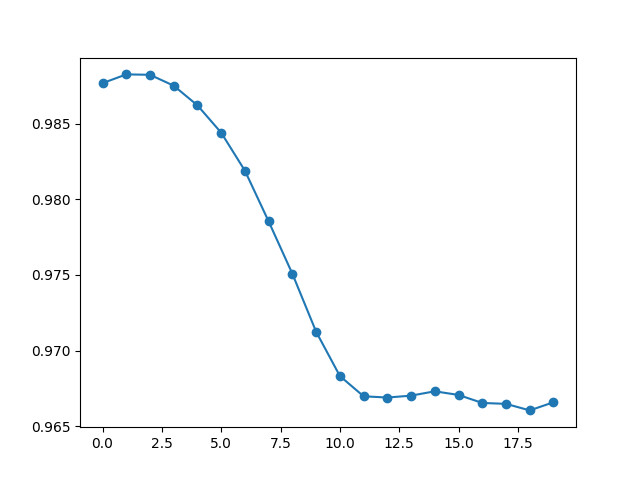

In [808]:
plt.figure()
plt.plot(scs,'-o')

In [758]:
r2_score(np.reshape(Y2,[9*Y2.shape[0]]),np.reshape(pred,[9*pred.shape[0]]))


0.9707201535787977

<IPython.core.display.Javascript object>


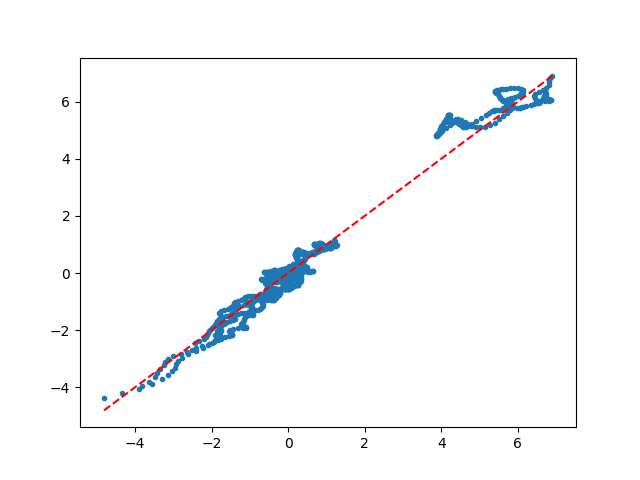

0.9665771752537052

In [809]:
plt.figure()
x=np.linspace(np.min(Y2),np.max(Y2),10)
plt.plot(x,x,'r--')
plt.scatter(np.reshape(Y2,[9*Y2.shape[0]]),np.reshape(pred,[9*pred.shape[0]]),marker='.')
r2_score(np.reshape(Y2,[9*Y2.shape[0]]),np.reshape(pred,[9*pred.shape[0]]))
#plt.plot(Y[:,1]*eps/K)
#plt.plot(pred[:,1]*eps/K)


In [552]:
Y2.shape

(12698, 9)

In [697]:
reg = xgb.XGBRegressor(objective ='reg:squarederror',max_depth=8,reg_lambda=0.8,random_state=10)
reg.fit(X,Y[:,4])

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=8, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=10, reg_alpha=0, reg_lambda=0.8, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [698]:
reg.score(X2,Y2[:,4])

0.7774029508215019

In [812]:
pred2=reg.predict(X2)

ValueError: feature_names mismatch: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18'] ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17']
expected f18 in input data

In [700]:
pred = reg.predict(X)

<IPython.core.display.Javascript object>


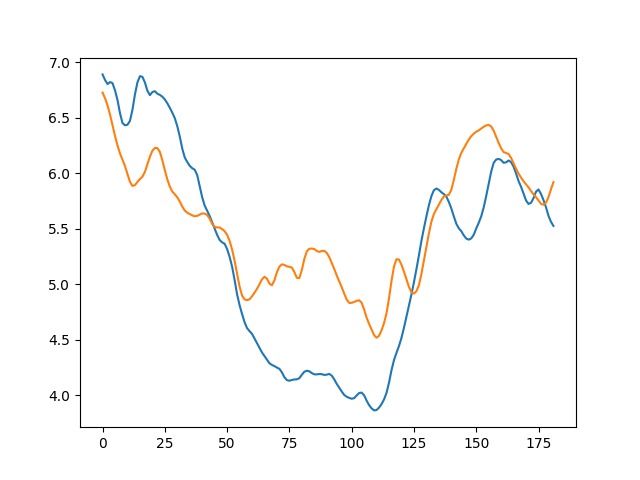

In [815]:
plt.figure()

plt.plot(Y2[:,1])
#plt.plot(Y[:,1])
#plt.plot(pred[:,1])
plt.plot(pred)


<IPython.core.display.Javascript object>


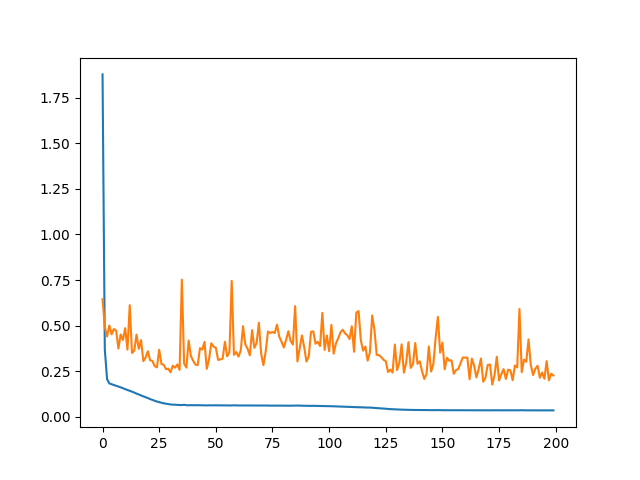

In [735]:
plt.figure()
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])

In [ ]:
pred = model.predict(X)
pred2 = model.predict(X2)

In [ ]:
pred.shape

In [ ]:
plt.figure()
plt.scatter(basis_vect[1,2,:,10],basis_vect[1,2,:,12])



In [ ]:
plt.figure()
#plt.plot(Y[:,1],'r-')
#plt.plot(pred[:,1],'r--')
plt.plot(Y2[:,8],'k-')
plt.plot(pred2[:,8],'k--')


In [ ]:
#_, _ , _ , eps, K = read_data('../GLM/t1')
_, _ , _ , eps2, K2, _, _ = read_data('../GLM/fine','059')
plt.figure(figsize=(10,10))
for i in range(0,3):
    for j in range(0,3):
        plt.subplot(3,3,i*3+j+1) 
        
        #plt.plot(Y[:,i*3+j]*eps/K,'r-')
        #plt.plot(pred[:,i*3+j]*eps/K,'k--')
        
        plt.plot(Y2[:,i*3+j]*eps2/K2,'k-')
        plt.plot(pred2[:,i*3+j]*eps2/K2,'k--')
        
        
        
        plt.locator_params(axis='y', nbins=4)
        plt.locator_params(axis='x', nbins=3)
        plt.title(str(i+1)+','+str(j+1))
        
        plt.gca().get_yaxis().set_major_formatter(ticker.FormatStrFormatter('%0.0e'))
        plt.gca().get_xaxis().set_major_formatter(ticker.FormatStrFormatter('%0.0e'))
        plt.grid(alpha=0.2)
        #if(i==0 and j==0):
        #    plt.legend(('DNS','Model'))
        plt.subplots_adjust(wspace=0.6)
        plt.subplots_adjust(hspace=0.6)
        #plt.gca().axes.get_yaxis().set_visible(False)
        #plt.gca().axes.get_xaxis().set_visible(False)
        #x = np.linspace(min(Gij[i,j,:]*eps/K),max(Gij[i,j,:]*eps/K),10)        
        #plt.plot(x,x,'k--')
#plt.savefig('Gij_linear_reg.png',dpi=300,bbox_inches = "tight")        

In [ ]:
def get_RSM(Gij,Tij):
    RSM = np.zeros((Gij.shape[0],3,3))
    Gij = np.reshape(Gij,(Gij.shape[0],3,3))
    Tij = np.reshape(Tij,(Tij.shape[0],3,3))
    for i in range(0,3):
        for j in range(0,3):
            for k in range(0,3):
                RSM[:,i,j]=RSM[:,i,j]+Gij[:,i,k]*Tij[:,k,j]+Gij[:,j,k]*Tij[:,k,i]
    return RSM

In [ ]:
def read_RSM(loc,d):
    ps = np.loadtxt(loc+'/press_strain_'+d+'.dat')
    pt = np.loadtxt(loc+'/press_trans_'+d+'.dat')
    K   = np.loadtxt(loc+'/k-eps_'+d+'.dat')    
    epsij   = np.loadtxt(loc+'/epsij_'+d+'.dat')    
    
    K   = K[:,0]
    
    index = np.where(K>0.05*np.max(K))    
    loend = index[0][0]
    hiend = index[0][-1]
   
    ps = ps[loend:hiend,:]
    pt = pt[loend:hiend,:]
    epsij = epsij[loend:hiend,:]
    
    RSM = ps-epsij-pt
    RSM = np.reshape(RSM,(ps.shape[0],3,3))
    
    
    return RSM


In [ ]:
RSM = read_RSM('../GLM/all','070')

In [ ]:
plt.figure()
plt.plot(RSM[:,2,2])
plt.plot(RSMT[:,2,2])

In [ ]:
Gij, Tij, _, _,_ = read_data('../GLM/all','070')

In [ ]:
#RSMT= get_RSM(pred2*eps2[:,None]/K2[:,None],Tij)
RSMT= get_RSM(Gij,Tij)

In [239]:
#dirs = ['035','042','047','053','057','062','066']
#dirs = ['019','022','024','026','028','031','033','035','037','039','042','044','046','048','051','053','055','057']
#dirs = ['104','107','024','026','028','031','033','035','037','039','042','044','046','048','051','053','055','057']

dir_loc = '../GLM/100/'
files = glob.glob(dir_loc+'accu*.dat')
indexes = [F[-7:-4] for F in files]

Gij, Tij , meanVelGrad , eps, K, Lij, Reyn = read_data(dir_loc,indexes[0])
for d in indexes[0:-1]:
    Gij1, Tij1 , meanVelGrad1 , eps1, K1, Lij1, Reyn1 = read_data(dir_loc,d)
    Gij = np.append(Gij,Gij1,axis=0)
    Tij = np.append(Tij,Tij1,axis=0)
    meanVelGrad = np.append(meanVelGrad,meanVelGrad1,axis=0)    
    eps = np.append(eps,eps1,axis=0)
    K = np.append(K,K1,axis=0)
    Lij = np.append(Lij,Lij1,axis=0)
    Reyn = np.append(Reyn,Reyn1,axis=0)

b = np.copy(Tij)
b[:,0] = b[:,0]-2.0*K/3.0
b[:,4] = b[:,4]-2.0*K/3.0
b[:,8] = b[:,8]-2.0*K/3.0
    
Gij2, Tij2 , meanVelGrad2 , eps2, K2, Lij2, Reyn2 = read_data(dir_loc,indexes[10])
b2 = np.copy(Tij2)
b2[:,0] = b2[:,0]-2.0*K2/3.0
b2[:,4] = b2[:,4]-2.0*K2/3.0
b2[:,8] = b2[:,8]-2.0*K2/3.0

    


In [240]:
Gij = np.reshape(Gij,(Gij.shape[0],3,3))
Tij = np.reshape(Tij,(Tij.shape[0],3,3))
meanVelGrad = np.reshape(meanVelGrad,(meanVelGrad.shape[0],3,3))
b = np.reshape(b,(b.shape[0],3,3))
Lij = np.reshape(Lij,(Lij.shape[0],3,3))

Gij2 = np.reshape(Gij2,(Gij2.shape[0],3,3))
Tij2 = np.reshape(Tij2,(Tij2.shape[0],3,3))
meanVelGrad2 = np.reshape(meanVelGrad2,(meanVelGrad2.shape[0],3,3))
b2 = np.reshape(b2,(b2.shape[0],3,3))
Lij2 = np.reshape(Lij2,(Lij2.shape[0],3,3))


In [241]:
Sij = np.zeros((b.shape[0],3,3))
omega = np.zeros((b.shape[0],3,3))
Sij2 = np.zeros((b2.shape[0],3,3))
omega2 = np.zeros((b2.shape[0],3,3))
for i in range(Sij.shape[0]):
    Sij[i,:,:] = 0.5*(meanVelGrad[i,:,:]+np.transpose(meanVelGrad[i,:,:]))
    omega[i,:,:] = 0.5*(meanVelGrad[i,:,:]-np.transpose(meanVelGrad[i,:,:]))
for i in range(Sij2.shape[0]):
    Sij2[i,:,:] = 0.5*(meanVelGrad2[i,:,:]+np.transpose(meanVelGrad2[i,:,:]))
    omega2[i,:,:] = 0.5*(meanVelGrad2[i,:,:]-np.transpose(meanVelGrad2[i,:,:]))
    

In [242]:
Gij = Gij*K[:,None,None]/eps[:,None,None]
Tij = Tij/K[:,None,None]
meanVelGrad = meanVelGrad*K[:,None,None]/eps[:,None,None]
b = b/(2.0*K[:,None,None])
Sij = Sij*K[:,None,None]/eps[:,None,None]
omega = omega*K[:,None,None]/eps[:,None,None]
Lij = Lij*K[:,None,None]


Gij2 = Gij2*K2[:,None,None]/eps2[:,None,None]
Tij2 = Tij2/K2[:,None,None]
meanVelGrad2 = meanVelGrad2*K2[:,None,None]/eps2[:,None,None]
b2 = b2/(2.0*K2[:,None,None])
Sij2 = Sij2*K2[:,None,None]/eps2[:,None,None]
omega2 = omega2*K2[:,None,None]/eps2[:,None,None]
Lij2 = Lij2*K2[:,None,None]


In [ ]:
def get_basis_vect(b,Sij,omega,meanVelGrad,Reyn):
    basis_vect = np.zeros((b.shape[0],3,3,21))
    for i in range(0,b.shape[0]):
        basis_vect[i,:,:,0]=np.eye(3,3)
        basis_vect[i,:,:,1]=b[i,:,:]
        basis_vect[i,:,:,2]=meanVelGrad[i,:,:]
        basis_vect[i,:,:,3]=np.matmul(b[i,:,:],b[i,:,:])
        basis_vect[i,:,:,4]=np.matmul(b[i,:,:],meanVelGrad[i,:,:])    
        basis_vect[i,:,:,5]=np.matmul(b[i,:,:],np.transpose(meanVelGrad[i,:,:]))
        basis_vect[i,:,:,6]=np.matmul(meanVelGrad[i,:,:],b[i,:,:])    
        basis_vect[i,:,:,7]=np.trace(b[i,:,:])*meanVelGrad[i,:,:]
        basis_vect[i,:,:,8]=np.trace(meanVelGrad[i,:,:])*b[i,:,:]
        basis_vect[i,:,:,9]=np.trace(meanVelGrad[i,:,:])*np.eye(3,3)
        basis_vect[i,:,:,10]=np.trace(b[i,:,:])*np.eye(3,3)
        basis_vect[i,:,:,11]=np.trace(np.matmul(b[i,:,:],b[i,:,:]))*np.eye(3,3)
        basis_vect[i,:,:,12]=np.trace(np.matmul(np.matmul(b[i,:,:],b[i,:,:]),b[i,:,:]))*np.eye(3,3)
        basis_vect[i,:,:,13]=np.trace(np.matmul(meanVelGrad[i,:,:],b[i,:,:]))*np.eye(3,3)
        basis_vect[i,:,:,14]=np.trace(np.matmul(np.matmul(meanVelGrad[i,:,:],b[i,:,:]),b[i,:,:]))*np.eye(3,3)  
        basis_vect[i,:,:,15]=Reyn[i]
             
        
    return basis_vect
        
        
        


In [ ]:
def get_basis_vect(b,Sij,omega,meanVelGrad):
    basis_vect = np.zeros((b.shape[0],3,3,21))
    for i in range(0,b.shape[0]):
        basis_vect[i,:,:,0]=np.eye(3,3)
        basis_vect[i,:,:,1]=b[i,:,:]
        basis_vect[i,:,:,2]=np.matmul(b[i,:,:],b[i,:,:])
        basis_vect[i,:,:,3]=np.trace(np.matmul(np.matmul(b[i,:,:],b[i,:,:]),b[i,:,:]))*np.eye(3,3)
        basis_vect[i,:,:,4]=meanVelGrad[i,:,:]
        basis_vect[i,:,:,5]=np.matmul(meanVelGrad[i,:,:],meanVelGrad[i,:,:])
        basis_vect[i,:,:,6]=np.matmul(np.matmul(meanVelGrad[i,:,:],meanVelGrad[i,:,:]),meanVelGrad[i,:,:])      
        basis_vect[i,:,:,7]=np.trace(meanVelGrad[i,:,:])*np.eye(3,3)        
        basis_vect[i,:,:,8]=np.transpose(meanVelGrad[i,:,:])
        basis_vect[i,:,:,9]=np.trace(np.matmul(meanVelGrad[i,:,:],b[i,:,:]))*np.eye(3,3)
        basis_vect[i,:,:,10]=np.transpose(np.matmul(b[i,:,:],np.transpose(meanVelGrad[i,:,:])))
        basis_vect[i,:,:,11]=np.transpose(np.matmul(b[i,:,:],meanVelGrad[i,:,:]))    
        basis_vect[i,:,:,12]=b[i,:,:]*np.trace(meanVelGrad[i,:,:])
        basis_vect[i,:,:,13]=np.matmul(b[i,:,:],meanVelGrad[i,:,:])    
        basis_vect[i,:,:,14]=np.matmul(b[i,:,:],np.transpose(meanVelGrad[i,:,:]))
        basis_vect[i,:,:,15]=np.trace(np.matmul(np.matmul(b[i,:,:],b[i,:,:]),b[i,:,:]))*np.eye(3,3)       
        basis_vect[i,:,:,16]=np.trace(np.matmul(b[i,:,:],b[i,:,:]))*np.eye(3,3)       
        basis_vect[i,:,:,17]=np.matmul(np.matmul(b[i,:,:],meanVelGrad[i,:,:]),meanVelGrad[i,:,:])
        basis_vect[i,:,:,18]=np.matmul(np.matmul(b[i,:,:],meanVelGrad[i,:,:]),np.transpose(meanVelGrad[i,:,:]))
        basis_vect[i,:,:,19]=np.matmul(np.matmul(b[i,:,:],np.transpose(meanVelGrad[i,:,:])),meanVelGrad[i,:,:])
        basis_vect[i,:,:,20] = -0.5*np.trace(np.matmul(Tij[i,:,:],np.transpose(meanVelGrad[i,:,:])) +\
                                np.transpose(np.matmul(Tij[i,:,:],np.transpose(meanVelGrad[i,:,:]))))*np.eye(3,3)
        
    return basis_vect
        
        
        


In [ ]:
def get_basis_vect(b,Sij,omega,meanVelGrad,Reyn):
    basis_vect = np.zeros((b.shape[0],3,3,19))
    basis_vect[:,:,:,0] = b
    basis_vect[:,:,:,1] = np.matmul(b,b)    
    basis_vect[:,:,:,2] = Sij
    basis_vect[:,:,:,3] = omega  
    basis_vect[:,:,:,4] = np.matmul(Sij,b)
    basis_vect[:,:,:,5] = np.matmul(omega,b)
    basis_vect[:,:,:,6] = np.matmul(b,Sij)
    basis_vect[:,:,:,7] = np.matmul(b,omega)

    basis_vect[:,:,:,8] = np.matmul(basis_vect[:,:,:,6],b)
    basis_vect[:,:,:,9] = np.matmul(basis_vect[:,:,:,7],b)
    basis_vect[:,:,:,10] = np.matmul(basis_vect[:,:,:,2],basis_vect[:,:,:,1])
    basis_vect[:,:,:,11] = np.matmul(basis_vect[:,:,:,3],basis_vect[:,:,:,1])
    basis_vect[:,:,:,12] = np.matmul(basis_vect[:,:,:,1],basis_vect[:,:,:,2])
    basis_vect[:,:,:,13] = np.matmul(basis_vect[:,:,:,1],basis_vect[:,:,:,3])
    basis_vect[:,:,:,14] = np.matmul(np.matmul(b,b),b)
    
    for i in range(0,b.shape[0]):
            basis_vect[i,:,:,15] = np.trace(Sij[i,:,:])*b[i,:,:]
            basis_vect[i,:,:,16] = Reyn[i]

            #basis_vect[i,:,:,15] = np.eye(3,3)*np.trace(Sij[i,:,:])            
            #basis_vect[i,:,:,16] = np.trace(basis_vect[i,:,:,4])*np.eye(3,3)
            #basis_vect[i,:,:,17] = np.trace(np.matmul(basis_vect[i,:,:,2],basis_vect[i,:,:,1]))*np.eye(3,3)
    
    return basis_vect           
       

    

In [ ]:
def get_basis_vect(b,Sij,omega,meanVelGrad,Reyn):
    basis_vect = np.zeros((b.shape[0],3,3,14))
    for i in range(0,b.shape[0]):
        basis_vect[i,:,:,0] = np.eye(3,3)
        basis_vect[i,:,:,1] = np.trace(Sij[i,:,:])*np.eye(3,3)
        basis_vect[i,:,:,2] = np.trace(np.matmul(Sij[i,:,:],b[i,:,:]))*np.eye(3,3)
        basis_vect[i,:,:,3] = b[i,:,:]
        basis_vect[i,:,:,4] = np.trace(Sij[i,:,:])*b[i,:,:]
        basis_vect[i,:,:,5] = np.trace(np.matmul(Sij[i,:,:],b[i,:,:]))*b[i,:,:]
        basis_vect[:,:,:,6] = Sij[i,:,:]    
        basis_vect[:,:,:,7] = omega[i,:,:]
        basis_vect[:,:,:,8] = np.matmul(Sij[i,:,:],b[i,:,:])
        basis_vect[:,:,:,9] = np.matmul(omega[i,:,:],b[i,:,:])
        basis_vect[:,:,:,10] = np.matmul(b[i,:,:],Sij[i,:,:])
        basis_vect[:,:,:,11] = np.matmul(b[i,:,:],omega[i,:,:])
        basis_vect[:,:,:,12] = np.matmul(np.matmul(b[i,:,:],Sij[i,:,:]),b[i,:,:])
        basis_vect[:,:,:,13] = np.matmul(np.matmul(b[i,:,:],omega[i,:,:]),b[i,:,:])   
        
        
    
    
    return basis_vect           
       

    

In [262]:
def get_basis_vect(b,Sij,omega,meanVelGrad,Reyn,Tij,eps,K):
    basis_vect = np.zeros((b.shape[0],3,3,42))
    for i in range(0,b.shape[0]):
        basis_vect[i,:,:,0] = np.eye(3,3)
        basis_vect[i,:,:,1] = b[i,:,:]
        basis_vect[i,:,:,2] = Sij[i,:,:]
        basis_vect[i,:,:,3] = omega[i,:,:]
        basis_vect[i,:,:,4] = np.matmul(b[i,:,:],b[i,:,:])
        basis_vect[i,:,:,5] = np.matmul(Sij[i,:,:],Sij[i,:,:])
        basis_vect[i,:,:,6] = np.matmul(omega[i,:,:],omega[i,:,:])
        basis_vect[i,:,:,7] = np.matmul(b[i,:,:],Sij[i,:,:])
        basis_vect[i,:,:,8] = np.matmul(b[i,:,:],omega[i,:,:])
        basis_vect[i,:,:,9] = np.matmul(Sij[i,:,:],b[i,:,:])
        basis_vect[i,:,:,10] = np.matmul(Sij[i,:,:],omega[i,:,:])
        basis_vect[i,:,:,11] = np.matmul(omega[i,:,:],b[i,:,:])
        basis_vect[i,:,:,12] = np.matmul(omega[i,:,:],Sij[i,:,:])      
        basis_vect[i,:,:,13] = np.matmul(np.matmul(b[i,:,:],b[i,:,:]),b[i,:,:])
        basis_vect[i,:,:,14] = np.matmul(np.matmul(Sij[i,:,:],Sij[i,:,:]),b[i,:,:])
        basis_vect[i,:,:,15] = np.matmul(np.matmul(b[i,:,:],Sij[i,:,:]),Sij[i,:,:])
        basis_vect[i,:,:,16] = np.matmul(np.matmul(Sij[i,:,:],b[i,:,:]),b[i,:,:])
        basis_vect[i,:,:,17] = np.matmul(np.matmul(b[i,:,:],b[i,:,:]),omega[i,:,:])
        basis_vect[i,:,:,18] = np.matmul(np.matmul(omega[i,:,:],omega[i,:,:]),b[i,:,:])
        basis_vect[i,:,:,19] = np.matmul(np.matmul(b[i,:,:],omega[i,:,:]),omega[i,:,:])
        basis_vect[i,:,:,20] = np.matmul(np.matmul(omega[i,:,:],b[i,:,:]),b[i,:,:])
        basis_vect[i,:,:,21] = np.matmul(np.matmul(b[i,:,:],Sij[i,:,:]),b[i,:,:])
        basis_vect[i,:,:,22] = np.matmul(np.matmul(b[i,:,:],omega[i,:,:]),b[i,:,:])
        basis_vect[i,:,:,23] = np.matmul(np.matmul(Sij[i,:,:],b[i,:,:]),Sij[i,:,:])
        basis_vect[i,:,:,24] = np.matmul(np.matmul(omega[i,:,:],b[i,:,:]),omega[i,:,:])
        
        basis_vect[i,:,:,25] = np.matmul(np.matmul(Sij[i,:,:],Sij[i,:,:]),omega[i,:,:])
        basis_vect[i,:,:,26] = np.matmul(np.matmul(omega[i,:,:],omega[i,:,:]),Sij[i,:,:])
        basis_vect[i,:,:,27] = np.matmul(np.matmul(Sij[i,:,:],omega[i,:,:]),omega[i,:,:])
        basis_vect[i,:,:,28] = np.matmul(np.matmul(omega[i,:,:],Sij[i,:,:]),Sij[i,:,:])
        
        basis_vect[i,:,:,29] = np.trace(Sij[i,:,:])*np.eye(3,3)
        basis_vect[i,:,:,30] = np.trace(np.matmul(b[i,:,:],Sij[i,:,:]))*np.eye(3,3)
        basis_vect[i,:,:,31] = np.trace(np.matmul(b[i,:,:],omega[i,:,:]))*np.eye(3,3)
        basis_vect[i,:,:,32] = np.trace(np.matmul(b[i,:,:],Sij[i,:,:]))*b[i,:,:]
        basis_vect[i,:,:,33] = np.trace(Sij[i,:,:])*b[i,:,:]
        basis_vect[i,:,:,34] = np.matmul(np.matmul(b[i,:,:],b[i,:,:]),np.matmul(Sij[i,:,:],Sij[i,:,:]))
        basis_vect[i,:,:,35] = np.matmul(np.matmul(Sij[i,:,:],Sij[i,:,:]),np.matmul(b[i,:,:],b[i,:,:]))
        basis_vect[i,:,:,36] = np.matmul(np.matmul(b[i,:,:],Sij[i,:,:]),np.matmul(b[i,:,:],b[i,:,:]))
        basis_vect[i,:,:,37] = np.matmul(np.matmul(Sij[i,:,:],b[i,:,:]),np.matmul(Sij[i,:,:],Sij[i,:,:]))
        
        basis_vect[i,:,:,38] = np.matmul(np.matmul(b[i,:,:],b[i,:,:]),np.matmul(omega[i,:,:],omega[i,:,:]))
        basis_vect[i,:,:,39] = np.matmul(np.matmul(omega[i,:,:],omega[i,:,:]),np.matmul(b[i,:,:],b[i,:,:]))
        basis_vect[i,:,:,40] = np.matmul(np.matmul(b[i,:,:],omega[i,:,:]),np.matmul(b[i,:,:],b[i,:,:]))
        basis_vect[i,:,:,41] = np.matmul(np.matmul(omega[i,:,:],b[i,:,:]),np.matmul(omega[i,:,:],omega[i,:,:]))
        
        
        
        
        
        
        #basis_vect[i,:,:,34] = np.trace(np.matmul(b[i,:,:],Sij[i,:,:]))*Sij[i,:,:]
        #basis_vect[i,:,:,35] = np.trace(np.matmul(b[i,:,:],omega[i,:,:]))*Sij[i,:,:]
        #basis_vect[i,:,:,36] = np.trace(np.matmul(b[i,:,:],b[i,:,:]))*omega[i,:,:]
        
        
        
    
    return basis_vect           
       

    

In [211]:
def get_basis_vect(b,Sij,omega,meanVelGrad,Reyn,Tij):
    basis_vect = np.zeros((b.shape[0],3,3,29))
    for i in range(0,b.shape[0]):
        basis_vect[i,:,:,0]=np.eye(3,3)
        basis_vect[i,:,:,1]=b[i,:,:]
        basis_vect[i,:,:,2]=meanVelGrad[i,:,:]
        basis_vect[i,:,:,3]=np.matmul(b[i,:,:],b[i,:,:])
        basis_vect[i,:,:,4]=np.matmul(meanVelGrad[i,:,:],meanVelGrad[i,:,:])            
        basis_vect[i,:,:,5]=np.matmul(b[i,:,:],meanVelGrad[i,:,:])
        basis_vect[i,:,:,6]=np.matmul(meanVelGrad[i,:,:],b[i,:,:])            
        basis_vect[i,:,:,7]=np.matmul(np.matmul(b[i,:,:],b[i,:,:]),meanVelGrad[i,:,:])
        basis_vect[i,:,:,8]=np.matmul(np.matmul(meanVelGrad[i,:,:],meanVelGrad[i,:,:]),b[i,:,:])
        basis_vect[i,:,:,9]=np.matmul(np.matmul(b[i,:,:],meanVelGrad[i,:,:]),meanVelGrad[i,:,:])
        basis_vect[i,:,:,10]=np.matmul(np.matmul(meanVelGrad[i,:,:],b[i,:,:]),b[i,:,:])
        basis_vect[i,:,:,11]=np.matmul(basis_vect[i,:,:,3],basis_vect[i,:,:,4])        
        basis_vect[i,:,:,12]=np.matmul(np.matmul(meanVelGrad[i,:,:],meanVelGrad[i,:,:]),basis_vect[i,:,:,3])        
        basis_vect[i,:,:,13]=np.matmul(b[i,:,:],basis_vect[i,:,:,10])
        basis_vect[i,:,:,14]=np.matmul(meanVelGrad[i,:,:],basis_vect[i,:,:,9])
        basis_vect[i,:,:,15]=np.matmul(b[i,:,:],basis_vect[i,:,:,12])
        basis_vect[i,:,:,16]=np.matmul(meanVelGrad[i,:,:],basis_vect[i,:,:,11])     
        
        basis_vect[i,:,:,17] = np.trace(basis_vect[i,:,:,1])*np.eye(3,3)
        basis_vect[i,:,:,18] = np.trace(basis_vect[i,:,:,2])*np.eye(3,3)
        basis_vect[i,:,:,19] = np.trace(basis_vect[i,:,:,3])*np.eye(3,3)
        basis_vect[i,:,:,20] = np.trace(basis_vect[i,:,:,4])*np.eye(3,3)
        basis_vect[i,:,:,21] = np.trace(basis_vect[i,:,:,5])*np.eye(3,3)
        basis_vect[i,:,:,22] = np.trace(basis_vect[i,:,:,7])*np.eye(3,3)
        basis_vect[i,:,:,23] = np.trace(basis_vect[i,:,:,8])*np.eye(3,3)
        basis_vect[i,:,:,24] = np.trace(basis_vect[i,:,:,11])*np.eye(3,3)
        
        basis_vect[i,:,:,25] = np.trace(Tij[i,:,:])*meanVelGrad[i,:,:]
        basis_vect[i,:,:,26] = np.trace(basis_vect[i,:,:,5])*meanVelGrad[i,:,:]
        #basis_vect[i,:,:,27] = np.trace(np.matmul(b[i,:,:],meanVelGrad[i,:,:]))*b[i,:,:]
        #basis_vect[i,:,:,27] = np.trace(basis_vect[i,:,:,5])*b[i,:,:]
        
        
        
        
        
        
        
             
        
    return basis_vect
        
        
        
        


In [144]:
def get_basis_vect(b,Sij,omega,meanVelGrad,Reyn,Tij,eps,K):
    #LIPM Basis
    basis_vect = np.zeros((b.shape[0],3,3,29))
    for i in range(0,b.shape[0]):        
        
        P = - 0.5*np.trace(np.matmul(Tij[i,:,:],np.transpose(meanVelGrad[i,:,:])) + np.transpose(np.matmul(Tij[i,:,:],np.transpose(meanVelGrad[i,:,:]))))
        B3 = np.matmul(np.matmul(b[i,:,:],b[i,:,:]),b[i,:,:])
        
        
        basis_vect[i,:,:,0] = np.eye(3,3)*eps[i]/K[i]
        basis_vect[i,:,:,1] = np.eye(3,3)*np.trace(B3)
        basis_vect[i,:,:,2] = np.eye(3,3)*P/eps[i] #P is non dim so no omega here
        basis_vect[i,:,:,3] = b[i,:,:]
        basis_vect[i,:,:,4] = np.matmul(b[i,:,:],b[i,:,:])
        basis_vect[i,:,:,5] = np.eye(3,3)*np.trace(meanVelGrad[i,:,:]) 
        basis_vect[i,:,:,6] = meanVelGrad[i,:,:]
        basis_vect[i,:,:,7] = np.transpose(meanVelGrad[i,:,:]) 
        basis_vect[i,:,:,8] = np.matmul(b[i,:,:],meanVelGrad[i,:,:])
        basis_vect[i,:,:,9] = np.matmul(b[i,:,:],np.transpose(meanVelGrad[i,:,:]))       
        
        
    return basis_vect
        
        
        


In [258]:
#for i, d in enumerate(indexes[1:]):
#    print(i,d)

len(indexes)


64

In [297]:
def get_training_data(dir_loc,normalise=True):

    files = glob.glob(dir_loc+'accu*.dat')
    indexes = [F[-7:-4] for F in files]        
    loindices = np.zeros(len(indexes)+1)
    Gij, Tij , meanVelGrad , eps, K, Lij, Reyn = read_data(dir_loc,indexes[0])
    loindices[1] = K.shape[0]
    for i, d in enumerate(indexes[1:]):
        Gij1, Tij1 , meanVelGrad1 , eps1, K1, Lij1, Reyn1 = read_data(dir_loc,d)
        loindices[i+2] = loindices[i+1]+K1.shape[0]
        Gij = np.append(Gij,Gij1,axis=0)
        Tij = np.append(Tij,Tij1,axis=0)
        meanVelGrad = np.append(meanVelGrad,meanVelGrad1,axis=0)    
        eps = np.append(eps,eps1,axis=0)
        K = np.append(K,K1,axis=0)
        Lij = np.append(Lij,Lij1,axis=0)
        Reyn = np.append(Reyn,Reyn1,axis=0)

    b = np.copy(Tij)
    b[:,0] = b[:,0]-2.0*K/3.0
    b[:,4] = b[:,4]-2.0*K/3.0
    b[:,8] = b[:,8]-2.0*K/3.0
    Gij = np.reshape(Gij,(Gij.shape[0],3,3))
    Tij = np.reshape(Tij,(Tij.shape[0],3,3))
    meanVelGrad = np.reshape(meanVelGrad,(meanVelGrad.shape[0],3,3))
    b = np.reshape(b,(b.shape[0],3,3))
    Lij = np.reshape(Lij,(Lij.shape[0],3,3))

    Sij = np.zeros((b.shape[0],3,3))
    omega = np.zeros((b.shape[0],3,3))
    
    for i in range(Sij.shape[0]):
        Sij[i,:,:] = 0.5*(meanVelGrad[i,:,:]+np.transpose(meanVelGrad[i,:,:]))
        omega[i,:,:] = 0.5*(meanVelGrad[i,:,:]-np.transpose(meanVelGrad[i,:,:]))
        
    if(normalise):    
        Gij = Gij*K[:,None,None]/eps[:,None,None]
        Tij = Tij/K[:,None,None]
        meanVelGrad = meanVelGrad*K[:,None,None]/eps[:,None,None]
        b = b/(2.0*K[:,None,None])
        Sij = Sij*K[:,None,None]/eps[:,None,None]
        omega = omega*K[:,None,None]/eps[:,None,None]
        Lij = Lij*K[:,None,None]
        
    basis_vect = get_basis_vect(b,Sij,omega,meanVelGrad,Reyn,Tij,eps,K)
    basis_vect = np.moveaxis(basis_vect,0,-2)
    Gij = np.moveaxis(Gij,0,-1)
    Tij = np.moveaxis(Tij,0,-1)
    Lij = np.moveaxis(Lij,0,-1)
    b = np.moveaxis(b,0,-1)
    meanVelGrad = np.moveaxis(meanVelGrad,0,-1)
        
    return Gij, Tij, meanVelGrad, b, Sij, omega, Lij, eps, K, basis_vect, loindices.astype(int) 


In [309]:
Gij, Tij, meanVelGrad, b, Sij, omega, Lij, eps, K, basis_vect, loindices = get_training_data('../GLM/100/')

In [310]:
Gij2, Tij2, meanVelGrad2, b2, Sij2, omega2, Lij2, eps2, K2, basis_vect2, loindices2 = get_training_data('../GLM/50/')

In [299]:
loindices2

array([    0,   139,   280,   423,   568,   715,   865,  1017,  1171,
        1327,  1485,  1645,  1807,  1971,  2137,  2305,  2474,  2645,
        2818,  2993,  3169,  3348,  3529,  3712,  3897,  4084,  4273,
        4464,  4656,  4850,  5046,  5243,  5442,  5643,  5846,  6051,
        6257,  6465,  6675,  6887,  7100,  7314,  7530,  7748,  7968,
        8189,  8412,  8637,  8864,  9092,  9321,  9552,  9784, 10018,
       10254, 10492, 10731, 10971, 11213, 11457, 11702, 11949, 12197,
       12447, 12698])

In [ ]:
pickle.dump(reg, open('lin_test.pkl', 'wb'))

In [ ]:
eps2.shape

In [ ]:
plt.figure()
plt.plot(np.trace(Gij,axis1=0,axis2=1)*eps/K)
#plt.plot(meanVelGrad2[:,0,0]+meanVelGrad2[:,1,1]+meanVelGrad2[:,2,2])

In [264]:
basis_vect=get_basis_vect(b,Sij,omega,meanVelGrad,Reyn,Tij)
basis_vect2=get_basis_vect(b2,Sij2,omega2,meanVelGrad2,Reyn2,Tij2)

basis_vect = np.moveaxis(basis_vect,0,-2)
Gij = np.moveaxis(Gij,0,-1)
Tij = np.moveaxis(Tij,0,-1)
Lij = np.moveaxis(Lij,0,-1)
b = np.moveaxis(b,0,-1)
meanVelGrad = np.moveaxis(meanVelGrad,0,-1)


basis_vect2 = np.moveaxis(basis_vect2,0,-2)
Gij2 = np.moveaxis(Gij2,0,-1)
Tij2 = np.moveaxis(Tij2,0,-1)
Lij2 = np.moveaxis(Lij2,0,-1)
b2 = np.moveaxis(b2,0,-1)
meanVelGrad2 = np.moveaxis(meanVelGrad2,0,-1)

TypeError: get_basis_vect() missing 2 required positional arguments: 'eps' and 'K'

In [302]:
loindices2

array([    0,   139,   280,   423,   568,   715,   865,  1017,  1171,
        1327,  1485,  1645,  1807,  1971,  2137,  2305,  2474,  2645,
        2818,  2993,  3169,  3348,  3529,  3712,  3897,  4084,  4273,
        4464,  4656,  4850,  5046,  5243,  5442,  5643,  5846,  6051,
        6257,  6465,  6675,  6887,  7100,  7314,  7530,  7748,  7968,
        8189,  8412,  8637,  8864,  9092,  9321,  9552,  9784, 10018,
       10254, 10492, 10731, 10971, 11213, 11457, 11702, 11949, 12197,
       12447, 12698])

In [ ]:
reg = pickle.load(open('lin_test.pkl', 'rb'))

In [332]:
X2 = np.copy(basis_vect2[:,:,:,0:nfs])
Y2 = np.copy(Gij2)
data2 = np.reshape(X2,[3*3*K2.shape[0],nfs])    
targ2 = np.reshape(Y2,[3*3*K2.shape[0]])
score = np.zeros(len(loindices2)-2)
for i in range(0,len(loindices2)-2):
    pred = reg.predict(data2[loindices2[i]:loindices2[i+1],:])
    score[i] = r2_score(targ2[loindices2[i]:loindices2[i+1]],pred)


ValueError: cannot reshape array of size 152 into shape (3,3,4795)

In [327]:
targ2.shape

(43155,)

In [333]:
pred = reg.predict(data2)
pred = np.reshape(pred,[3,3,K2.shape[0]]) 

In [331]:
r2_score(targ2[loindices2[0]:loindices[1]],pred[loindices2[0]:loindices[1]])

-40.03196574157897

<IPython.core.display.Javascript object>


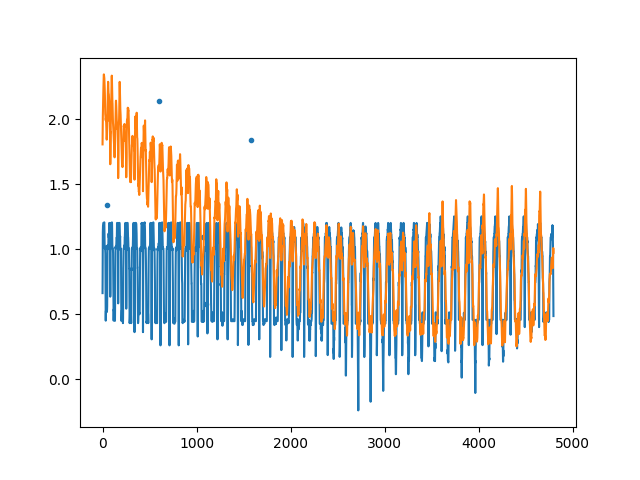

In [335]:
plt.figure()
#plt.plot(score,'-o')
plt.plot(pred[0,0,:])
plt.plot(Gij2[0,0,:])


In [315]:
#nfs=18
X = np.copy(basis_vect[:,:,:,0:nfs])
Y = np.copy(Gij)
data = np.reshape(X,[3*3*K.shape[0],nfs])    
targ = np.reshape(Y,[3*3*K.shape[0]])

#weights = np.ones((3,3,Y.shape[2]))*eps[None,None,:]/K[None,None,:]
#weights = np.reshape(weights,[3*3*K.shape[0]])
    
#weights2 = np.ones((3,3,Y2.shape[2]))*eps2[None,None,:]/K2[None,None,:]
#weights2 = np.reshape(weights2,[3*3*K2.shape[0]])


X_train, X_test, Y_train, Y_test  =  train_test_split(data,targ,test_size=0.2,random_state=1)

mses = np.zeros(40)
for nfs in range(39,40):
    print(nfs)
    slope = np.zeros((3,3,nfs))
    intercept = np.zeros((3,3,nfs))       

      
    
    #reg = LR(normalize=False,fit_intercept=True).fit(data,targ,sample_weight=weights)
    #reg = RandomForestRegressor(n_estimators=100,max_depth=10,max_features=0.8).fit(data,targ)
    #reg = SVR(kernel='linear').fit(data,targ,sample_weight=weights)
    
    #reg = Lasso(alpha=0.001,max_iter=1e6,fit_intercept=True,random_state=10).fit(data,targ)
    #reg = LassoCV(eps=1e-2,fit_intercept=True,cv=8,random_state=10).fit(data,targ)

    #reg = RidgeCV(alphas=(0.5,0.01,0.001,0.0001,0.00005),cv=5).fit(data,targ,sample_weight=weights)
    #data_dmatrix = xgb.DMatrix(data=data,label=targ)
    reg = xgb.XGBRegressor(objective ='reg:squarederror')
    reg.fit(X_train,Y_train)
    



    #mse_t=mean_squared_error(targ,reg.predict(data))
    #mse_v=mean_squared_error(targ2,reg.predict(data2))
    #mses[nfs]=mse_t
    predict = reg.predict(X_test)
    sc = reg.score(X_test,Y_test)
    sc2 = reg.score(X_train,Y_train)

    #predict = np.reshape(predict,[3,3,int(Y_test.shape[0]/9)])

39


In [316]:
sc

0.9880745663797131

<IPython.core.display.Javascript object>


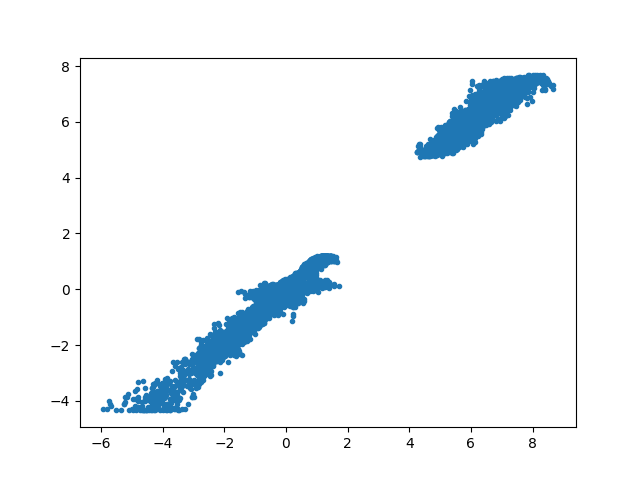

In [317]:
plt.figure()
plt.scatter(Y_test,predict,marker='.')

In [193]:
sc

0.8193793573433319

In [ ]:
predict = np.reshape(predict,[K2.shape[0],3,3])

In [ ]:
plt.figure()
plt.plot(Y2[0,0,:]*eps2/K2)
plt.plot(predict[0,0,:])

In [ ]:
reg.coef_

In [ ]:
imps =[0]
for i in range(1,22):
    imps.append(mses[i-1]-mses[i])
imps[1]=0

In [ ]:
[i for i in imps]


In [ ]:
plt.figure()
plt.bar(range(0,17),imps)

In [ ]:
#nfs=18
mses = np.zeros(37)
for nfs in range(1,37):
    print(nfs)
    slope = np.zeros((3,3,nfs))
    intercept = np.zeros((3,3,nfs))       

      
    X = np.zeros((3,K.shape[0],nfs))
    X2 = np.zeros((3,K2.shape[0],nfs))
    Y = np.zeros((3,K.shape[0]))
    Y2 = np.zeros((3,K2.shape[0]))
    
    for i in range(0,3):
        X[i,:,:] = basis_vect[i,i,:,0:nfs]
        X2[i,:,:] = basis_vect2[i,i,:,0:nfs]
        Y[i,:] = Gij[i,i,:]
        Y2[i,:] = Gij2[i,i,:]
        
        
    
    
    #X = np.copy(basis_vect[0:+1,0:2,:,0:nfs])
    #Y = np.copy(Gij[0:1,0:2,:])
    #X2 = np.copy(basis_vect2[0:1,0:2,:,0:nfs])
    #Y2 = np.copy(Gij2[0:1,0:2,:])
    
    

    data = np.reshape(X,[3*K.shape[0],nfs])
    data2 = np.reshape(X2,[3*K2.shape[0],nfs])
    
    targ = np.reshape(Y,[3*K.shape[0]])
    targ2 = np.reshape(Y2,[3*K2.shape[0]])

    weights = np.ones((1,3,K.shape[0]))*eps[None,None,:]/K[None,None,:]
    weights = np.reshape(weights,[3*K.shape[0]])
    
    weights2 = np.ones((1,3,K2.shape[0]))*eps2[None,None,:]/K2[None,None,:]
    weights2 = np.reshape(weights2,[3*K2.shape[0]])
     
    #reg = LR(normalize=False,fit_intercept=True).fit(data,targ,sample_weight=weights)
    
    #reg = Lasso(alpha=0.0001,max_iter=1e6,fit_intercept=True,random_state=10).fit(data,targ)
    #reg = LassoCV(eps=1e-4,max_iter=1e6,fit_intercept=True,cv=8,random_state=10).fit(data,targ)

    reg = RidgeCV(alphas=(0.01,0.001,0.0001,0.00005,0.00001,1e-6,5e-6,1e-7),cv=5).fit(data,targ,sample_weight=weights)

    mse_t=mean_squared_error(targ,reg.predict(data))
    mse_v=mean_squared_error(targ2,reg.predict(data2))
    mses[nfs-1]=mse_t
    predict = reg.predict(data2)
    sc = reg.score(data2,targ2,sample_weight=weights2)
    predict = np.reshape(predict,[1,3,K2.shape[0]])

In [ ]:
sc

In [ ]:
mses

In [ ]:
reg.alpha_

In [ ]:
imps =[0]
for i in range(1,34):
    imps.append(mses[i-1]-mses[i])
#imps[1]=0

In [ ]:
predict.shape

In [ ]:
plt.figure()
plt.plot(Gij2[2,2,:])
plt.plot(predict[0,2,:])


In [ ]:
predict.shape

In [ ]:
sc

In [ ]:
reg.coef_

In [ ]:
slope[0,0,:]

In [ ]:
mse_t

In [ ]:
nfs = 10
slope = np.zeros((3,3,nfs))
predict = np.zeros((3,3,K2.shape[0]))
sc = np.zeros((3,3))
mse_t=0
mse_v=0

#X = basis_vect[:,:,:,0:nfs]*eps[None,None,:,None]/K[None,None,:,None]
#Y = Gij*eps[None,None,:]/K[None,None,:]

X = np.copy(basis_vect[:,:,:,0:nfs])
Y = np.copy(Gij)

#X2 = basis_vect2[:,:,:,0:nfs]*eps2[None,None,:,None]/K2[None,None,:,None]
#Y2 = Gij2*eps2[None,None,:]/K2[None,None,:]

X2 = np.copy(basis_vect2[:,:,:,0:nfs])
Y2 = np.copy(Gij2)

r2sc = np.zeros((3,3))

for i in range(0,3):
    for j in range(0,3):
        
        
        #reg = LR(fit_intercept=False).fit(X[i,j,:,0:nfs]*eps[:,None]/K[:,None],Y[i,j,:]*eps/K)
        #reg = LassoCV(eps=1e-6,max_iter=1000000,cv=4).fit(basis_vect[i,j,:,0:nfs],Gij[i,j,:])
        
        #reg = RidgeCV(alphas=(0.1,0.01,0.001,0.0001,0.00005,0.00001,1e-6),cv=10).fit(X[i,j,:,0:nfs],Y[i,j,:])
        slope[i,j,:]=reg.coef_

        mse_t = mse_t + mean_squared_error(Y[i,j,:],reg.predict(X[i,j,:,0:nfs]))
        
        predict[i,j,:] = reg.predict(X2[i,j,:,0:nfs]*eps2[:,None]/K2[:,None])
        r2sc[i,j] = r2_score(Y2[i,j,:]*eps2/K2,predict[i,j,:]*eps2/K2)
        mse_v = mse_v + mean_squared_error(Y2[i,j,:],reg.predict(X2[i,j,:,0:nfs]))
        sc[i,j] = reg.score(X2[i,j,:,0:nfs],Y2[i,j,:],sample_weight=eps2/K2)

In [ ]:
slope[:,:,7]

In [ ]:
r2sc

In [ ]:
t = np.reshape(Gij2,[3*3*K2.shape[0]])

In [ ]:
p1 = np.reshape(predict,[3*3*K2.shape[0]])

In [ ]:
r2_score(t,p1)

In [288]:
predict.shape

(3, 3, 959)

<IPython.core.display.Javascript object>


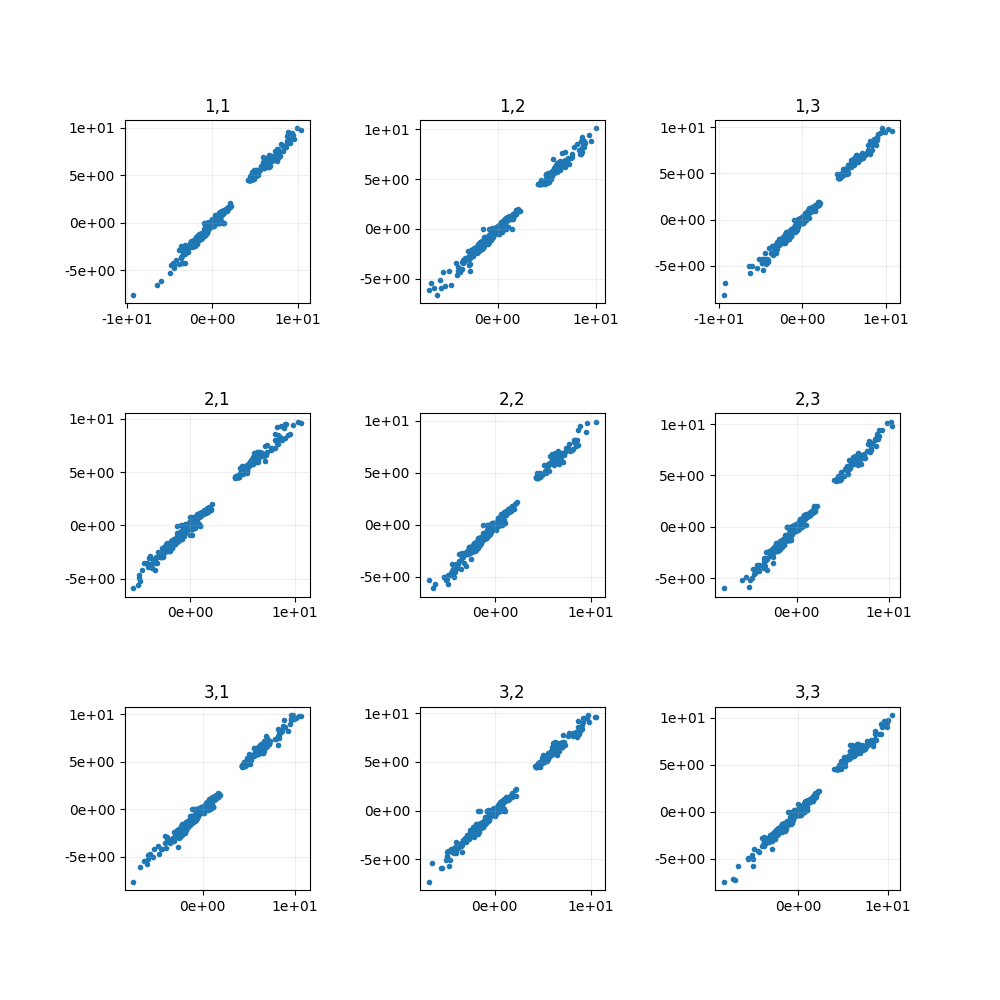

In [290]:
plt.figure(figsize=(10,10))
for i in range(0,3):
    for j in range(0,3):
        plt.subplot(3,3,i*3+j+1) 
        
        #plt.plot(Gij2[i,j,:]*eps2/K2)        
        #plt.plot(predict[i,j,:]*eps2/K2)
        
        #plt.plot(Gij[i,j,:]*eps/K)        
        #plt.plot(predict[i,j,:]*eps/K)
        
        
        #plt.scatter(Gij[i,j,:]*eps/K,predict[i,j,:]*eps/K,marker='.')
        Y2 = np.reshape(Y_test,[3,3,int(Y_test.shape[0]/9)])
        #plt.plot(Y2[i,j,:])
        #plt.plot(predict[i,j,:])
        
        plt.scatter(Y2[i,j,:],predict[i,j,:],marker='.')        
        #plt.plot(Gij[i,j,:]*eps/K)
        #plt.plot(LIPM[i,j,:])
        
        plt.locator_params(axis='y', nbins=4)
        plt.locator_params(axis='x', nbins=3)
        plt.title(str(i+1)+','+str(j+1))
        
        plt.gca().get_yaxis().set_major_formatter(ticker.FormatStrFormatter('%0.0e'))
        plt.gca().get_xaxis().set_major_formatter(ticker.FormatStrFormatter('%0.0e'))
        plt.grid(alpha=0.2)
        #if(i==0 and j==0):
        #    plt.legend(('DNS','Model'))
        plt.subplots_adjust(wspace=0.6)
        plt.subplots_adjust(hspace=0.6)
        #plt.gca().axes.get_yaxis().set_visible(False)
        #plt.gca().axes.get_xaxis().set_visible(False)
        #x = np.linspace(min(Gij[i,j,:]*eps/K),max(Gij[i,j,:]*eps/K),10)        
        
        #plt.plot(x,x,'k--')
#plt.savefig('Gij_linear_reg.png',dpi=300,bbox_inches = "tight")        

In [ ]:
Gijpred = predict*eps2[None,None,:]/K2[None,None,:]

In [ ]:
LIPM2.shape

In [ ]:
RSM = np.zeros((3,3,K2.shape[0]))
RSLIPM = np.zeros((3,3,K2.shape[0]))

for i in range(0,K2.shape[0]):
    RSM[:,:,i]  = np.matmul(Gijpred[:,:,i],Tij2[:,:,i]*K2[i]) + np.transpose(np.matmul(Gijpred[:,:,i],Tij2[:,:,i]*K2[i]))
    RSLIPM[:,:,i]  = np.matmul(LIPM2[:,:,i],Tij2[:,:,i]*K2[i]) + np.transpose(np.matmul(LIPM2[:,:,i],Tij2[:,:,i]*K2[i]))

In [ ]:
plt.figure()
loend=211
hiend=365
plt.plot(RSM[2,1,:])
plt.plot(RSLIPM[2,1,:])
plt.plot(ps[loend:hiend,7]-pt[loend:hiend,7]-epsij[loend:hiend,7])


In [ ]:
ps = np.loadtxt('../GLM/50/press_strain_219.dat')
pt = np.loadtxt('../GLM/50/press_trans_219.dat')
epsij = np.loadtxt('../GLM/50/epsij_219.dat')




In [ ]:
loend

In [ ]:
def LIPM_model(C0,CIPM,alpha2,alpha3,beta1,beta2,beta3,gama5,gama6,b,Tij,meanVelGrad,eps,K,lambdaij):
    pred = np.zeros((3,3,K.shape[0]))
    for i in range(0,K.shape[0]):        
        P = - 0.5*np.trace(np.matmul(Tij[:,:,i],np.transpose(meanVelGrad[:,:,i])) + np.transpose(np.matmul(Tij[:,:,i],np.transpose(meanVelGrad[:,:,i]))))
        B3 = np.matmul(np.matmul(b[:,:,i],b[:,:,i]),b[:,:,i])
        
        alpha1 = -(0.5+3.0/4*C0)+3.0*alpha2*np.trace(B3)+0.5*CIPM*P #P is non dim so no omega here
        
        pred[:,:,i] = alpha1*np.eye(3,3)+alpha2*b[:,:,i] + alpha3*np.matmul(b[:,:,i],b[:,:,i]) + beta1*np.eye(3,3)*np.trace(meanVelGrad[:,:,i]) + \
        beta2*meanVelGrad[:,:,i] + beta3*np.transpose(meanVelGrad[:,:,i]) + gama5*np.matmul(b[:,:,i],meanVelGrad[:,:,i]) + \
        gama6*np.matmul(b[:,:,i],np.transpose(meanVelGrad[:,:,i]))
        pred[:,:,i] = pred[:,:,i]*eps[i]/K[i]
        pred[:,:,i] = pred[:,:,i]+0.5*C0*eps[i]/K[i]*lambdaij[:,:,i]
    return pred

    

In [ ]:
Lij.shape

In [ ]:
LIPM  = LIPM_model(2.1,0.6,3.5,-3*3.5,-0.2,0.8,-0.2,0.6,-0.6,b,Tij,meanVelGrad,eps,K,Lij)
LIPM2 = LIPM_model(2.1,0.6,3.5,-3*3.5,-0.2,0.8,-0.2,0.6,-0.6,b2,Tij2,meanVelGrad2,eps2,K2,Lij2)

In [ ]:
def get_basis_LIPM(C0,CIPM,alpha2,alpha3,beta1,beta2,beta3,gama5,gama6,b,Tij,meanVelGrad):
        basis_vect = np.zeros((b.shape[2],3,3,10))
        for i in range(0,b.shape[2]):
            basis_vect[i,:,:,0]=np.eye(3,3)
            basis_vect[i,:,:,1]=b[:,:,i]
            basis_vect[i,:,:,2]=np.matmul(b[:,:,i],b[:,:,i])
            basis_vect[i,:,:,3]=np.trace(meanVelGrad[:,:,i])*np.eye(3,3)        
            basis_vect[i,:,:,4]=meanVelGrad[:,:,i]
            basis_vect[i,:,:,5]=np.transpose(meanVelGrad[:,:,i])
            basis_vect[i,:,:,6]=np.matmul(b[:,:,i],meanVelGrad[:,:,i])
            basis_vect[i,:,:,7]=np.matmul(b[:,:,i],np.transpose(meanVelGrad[:,:,i]))
            basis_vect[i,:,:,8]=np.trace(np.matmul(np.matmul(b[:,:,i],b[:,:,i]),b[:,:,i]))*np.eye(3,3)
            basis_vect[i,:,:,9]=- 0.5*np.trace(np.matmul(Tij[:,:,i],np.transpose(meanVelGrad[:,:,i])) +\
                                np.transpose(np.matmul(Tij[:,:,i],np.transpose(meanVelGrad[:,:,i]))))*np.eye(3,3)
        basis_vect = np.moveaxis(basis_vect,0,-2)
        return basis_vect
            

    

In [ ]:
b.shape

In [ ]:
basis_LIPM = get_basis_LIPM(2.1,0.6,3.5,-3*3.5,-0.2,0.8,-0.2,0.6,-0.6,b,Tij,meanVelGrad)
basis_LIPM2 = get_basis_LIPM(2.1,0.6,3.5,-3*3.5,-0.2,0.8,-0.2,0.6,-0.6,b2,Tij2,meanVelGrad2)


In [ ]:
P= -0.5*np.trace(np.matmul(Tij[:,:,i],np.transpose(meanVelGrad[:,:,i])) +\
                                np.transpose(np.matmul(Tij[:,:,i],np.transpose(meanVelGrad[:,:,i]))))

In [ ]:
P